In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [3]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [4]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

# Scenario 6

        PCa_b      Tref    perm50  CV_ventricles  a_ventricles   EDP_lv  \
0    0.000104  181.8800  0.432887       0.541089       1.47935  7.13285   
1    0.000093  117.2970  0.299218       0.435956       3.51870  4.36058   
2    0.000037   78.5908  0.318741       0.489729       3.26294  7.29318   
3    0.000068  204.1080  0.280034       0.564459       3.48290  5.81285   
4    0.000057  192.8150  0.303769       0.792342       2.23830  2.85869   
..        ...       ...       ...            ...           ...      ...   
995  0.000101  143.8110  0.200636       0.687560       3.18245  2.06155   
996  0.000128   93.3145  0.187213       0.655885       2.91642  1.75915   
997  0.000073   72.4349  0.509966       0.474934       1.80298  3.93620   
998  0.000145   79.0890  0.315106       0.396598       1.00549  7.17315   
999  0.000128  155.7950  0.484251       0.614842       1.89202  3.18508   

      EDP_rv     Rsys    Rpulm  
0    3.79291  2.75361  3.56667  
1    1.39339  2.78153  3.51396  


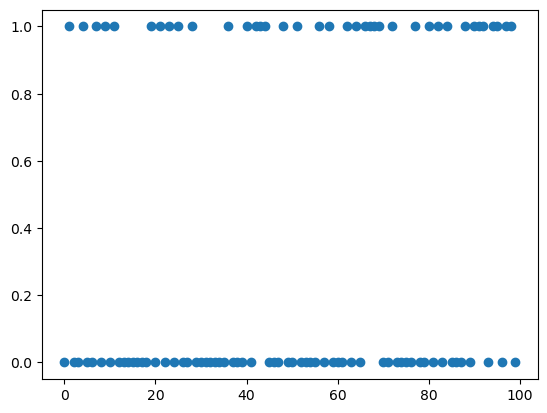

In [5]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [6]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [7]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[4.30915e-05, 0.000141663]
[60.0088, 213.146]
[0.193135, 0.518036]
[0.411063, 0.796491]
[1.50272, 4.95594]
[1.03757, 7.40647]
[1.03544, 7.09553]
[1.16178, 3.93971]
[1.01728, 3.95163]


In [8]:
x_all = torch.tensor(input_masked.values)

y_calibration = y_all.loc[:,['V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





In [9]:
y_max=y_calibration.max(axis=0)

In [10]:
y_test = y_calibration[y_max[1][2],:]
x_test = x_all[y_max[1][2],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


In [11]:
emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2


In [12]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test
obs_error=torch.tensor([0.1,0.1,0.01])

In [13]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [14]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-3080.525634765625
-192.45774841308594
-308.9199523925781
-371.7347106933594
-218.135986328125
-1888.543701171875
-30.32249641418457
-236.48538208007812
-3648.7333984375
-56.46287155151367
-2005.7376708984375
-92.85942840576172
-3040.54833984375
-118.28443145751953
-637.0482177734375
-12.47676944732666
-279.7673034667969
-138.45553588867188


In [15]:
sampler.run_mcmc(p0, 60000)

State([[1.38631273e-04 1.79354697e+02 5.14031238e-01 6.88738465e-01
  4.62404893e+00 1.96813581e+00 2.26750615e+00 1.51964000e+00
  2.33678821e+00]
 [1.19100414e-04 1.84719439e+02 2.22675508e-01 6.88140096e-01
  4.88096203e+00 3.80251487e+00 2.12459415e+00 1.58705100e+00
  2.72529898e+00]
 [1.32888927e-04 1.51172677e+02 5.07403268e-01 6.91520467e-01
  4.47760165e+00 4.95551310e+00 1.41732764e+00 2.26453870e+00
  2.50476378e+00]
 [1.08887149e-04 1.99876692e+02 3.91264080e-01 6.86893498e-01
  1.79682455e+00 3.03844960e+00 3.91242224e+00 1.60179356e+00
  3.61488996e+00]
 [1.19045624e-04 1.34484102e+02 4.89928820e-01 6.87723211e-01
  3.81948247e+00 3.22364317e+00 5.78141313e+00 2.96582638e+00
  1.47509235e+00]
 [1.05014786e-04 1.69338864e+02 4.54211157e-01 6.95263331e-01
  1.76933732e+00 4.59201462e+00 1.88971535e+00 2.10759033e+00
  2.95625318e+00]
 [9.34939041e-05 1.71524913e+02 2.96091122e-01 6.96839794e-01
  2.86271745e+00 6.10715793e+00 2.80928209e+00 1.51554688e+00
  2.56579907e+00]


In [16]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

(90000, 9)


In [17]:
x_test

tensor([1.3478e-04, 1.7398e+02, 4.0876e-01, 6.9157e-01, 3.1323e+00, 5.9912e+00,
        2.4626e+00, 1.1618e+00, 1.8602e+00], dtype=torch.float64)

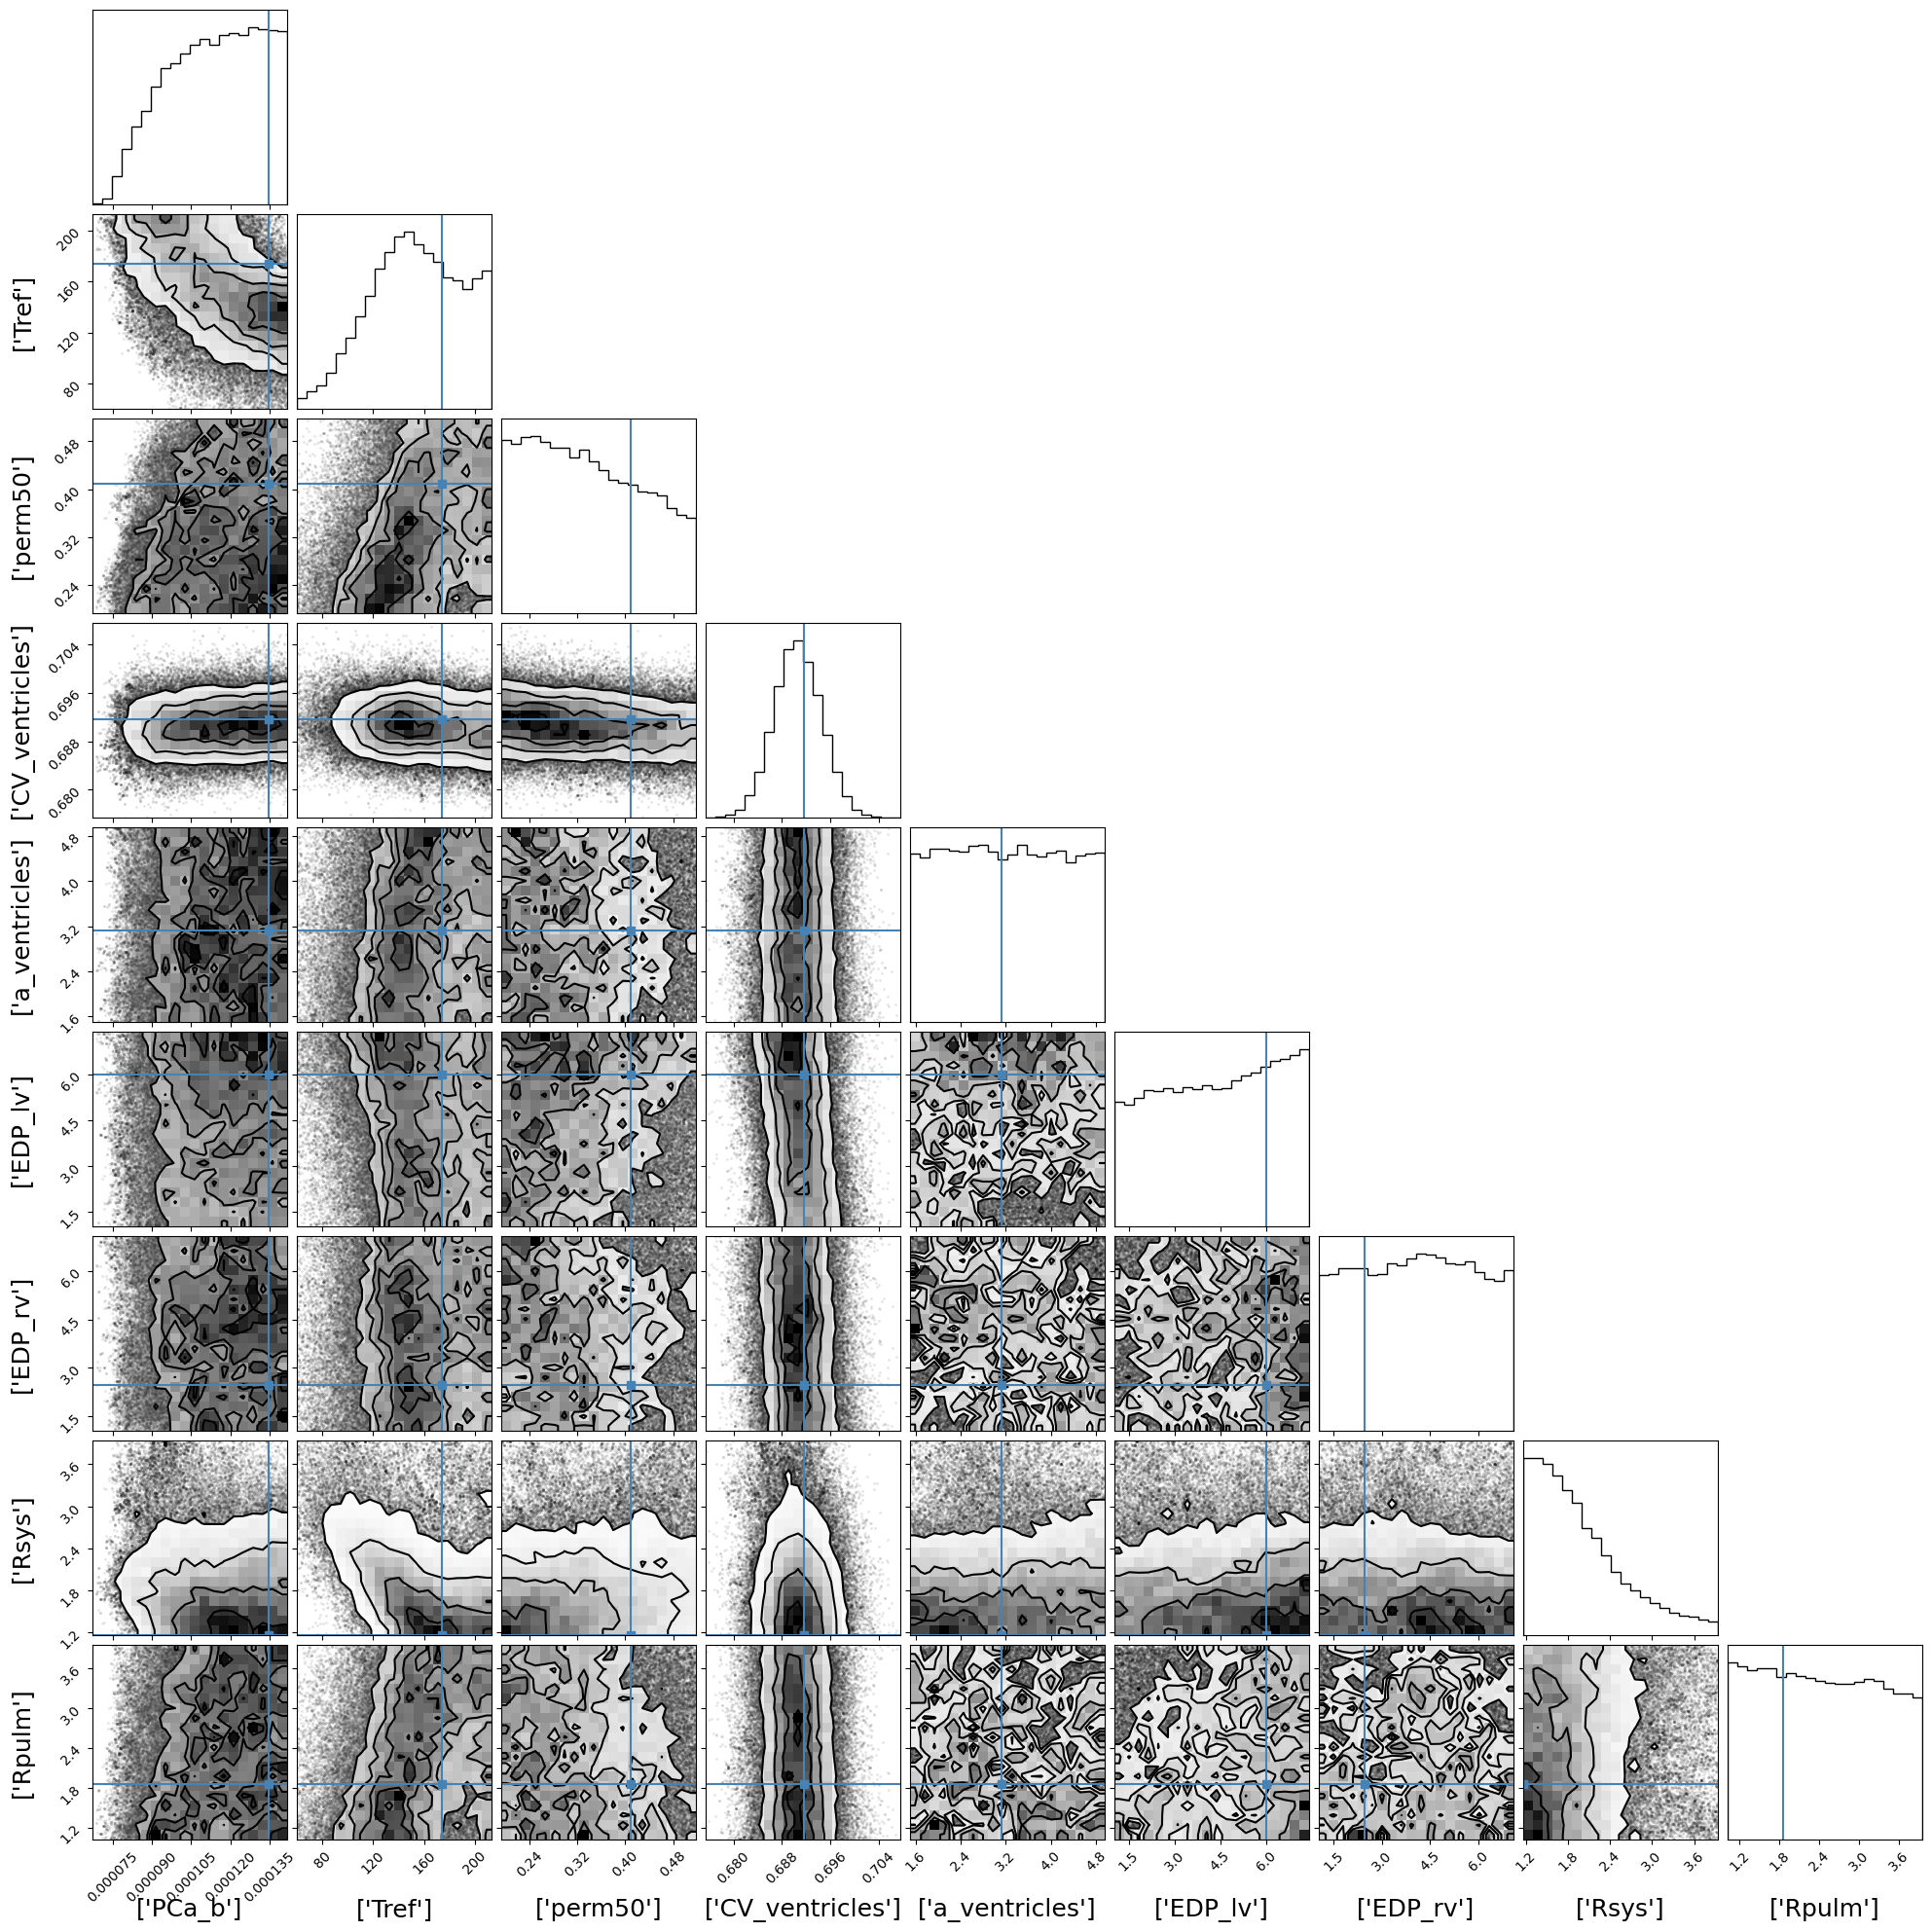

In [18]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

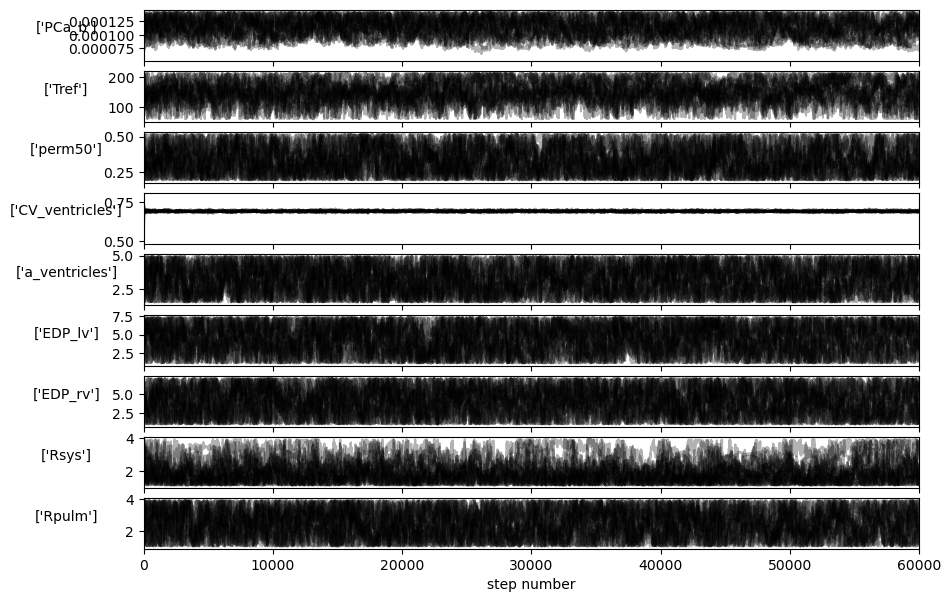

In [19]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [20]:
samp = pd.DataFrame(flat_samples).sample(50)

samp.to_csv("MCMC_samples_scenario_6_40.dat", sep = " ",index=False,header=None)

In [21]:
samp = pd.DataFrame(flat_samples)

samp.to_csv("MCMC_samples_scenario_6_40_full_posterior.dat", sep = " ",index=False,header=None)

In [22]:
flat_samples.shape

(90000, 9)

In [23]:
emulator.predict(torch.tensor(flat_samples)).shape

torch.Size([90000, 3])

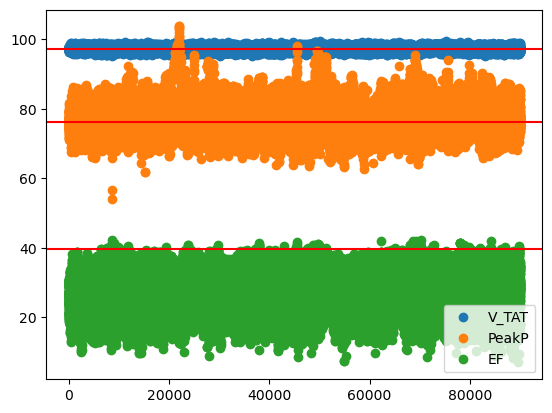

In [24]:
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,0:2].detach().numpy(),'o')
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,2].detach().numpy()*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2]*100, color='r', linestyle='-')

In [25]:
posterior=pd.read_csv("MCMC_samples_scenario_6_60_full_posterior.dat",delim_whitespace=True,header=None)

In [26]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2


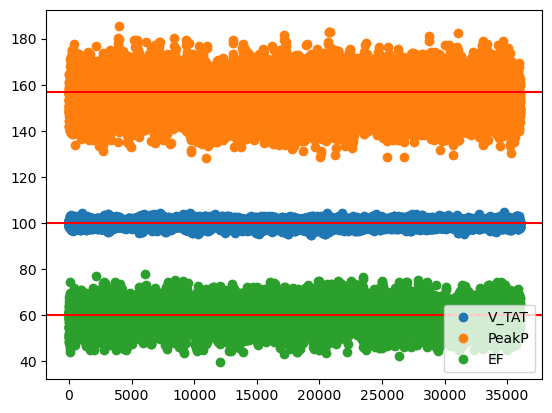

In [27]:
plt.plot(emulator.predict(torch.tensor(posterior.values))[:,0:2].detach().numpy(),'o')
plt.plot(emulator.predict(torch.tensor(posterior.values))[:,2].detach().numpy()*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')

plt.axhline(y=100, color='r', linestyle='-')
plt.axhline(y=157, color='r', linestyle='-')
plt.axhline(y=60, color='r', linestyle='-')


In [28]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_33021/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [29]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST       ST_conf
(PCa_b,)          0.000007  9.784262e-07
(Tref,)           0.000006  5.419866e-07
(perm50,)         0.000002  1.376602e-07
(CV_ventricles,)  1.000052  6.104996e-02
(a_ventricles,)   0.000028  3.077397e-06
(EDP_lv,)         0.000056  5.191548e-06
(EDP_rv,)         0.000042  5.434058e-06
(Rsys,)           0.000017  1.677170e-06
(Rpulm,)          0.000028  4.352634e-06
                            S1   S1_conf
(PCa_b,)          2.148364e-06  0.000243
(Tref,)          -1.765036e-05  0.000223
(perm50,)         1.296255e-09  0.000119
(CV_ventricles,)  9.999348e-01  0.079804
(a_ventricles,)   9.480563e-06  0.000504
(EDP_lv,)         3.492874e-05  0.000636
(EDP_rv,)         7.032225e-06  0.000605
(Rsys,)           8.413804e-05  0.000355
(Rpulm,)         -9.216627e-05  0.000393
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(PCa_b,)          0.710686  0.059708
(Tref,)           0.148196  0.015331
(perm50,)         0.

In [30]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

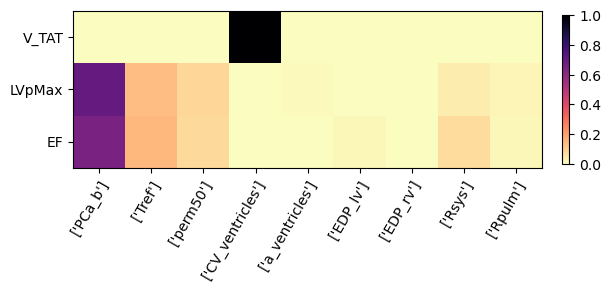

In [31]:
inputs = x_labels.values.tolist()
outputs = ['V_TAT','LVpMax','EF']
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [32]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = torch.tensor([100,157,0.6])
obs_error=torch.tensor([0.1,0.1,0.001])

In [33]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [34]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-3232.08642578125
-1049.413330078125
-4117.36669921875
-810.5401000976562
-4658.29541015625
-2291.876708984375
-547.7904663085938
-298.01763916015625
-838.009033203125
-5279.03466796875
-4709.24951171875
-258.1286926269531
-957.1793823242188
-1027.8138427734375
-4934.24560546875
-942.4940795898438
-935.7180786132812
-821.9530639648438


In [35]:
sampler.run_mcmc(p0, 40000)

State([[1.41141216e-04 2.12216522e+02 1.95055165e-01 6.72253892e-01
  1.58103944e+00 6.89723971e+00 1.03951979e+00 3.89743586e+00
  1.10254044e+00]
 [1.40178814e-04 2.11902825e+02 1.96810007e-01 6.69663733e-01
  1.61493425e+00 7.35570037e+00 1.87435975e+00 3.90364477e+00
  1.05713980e+00]
 [1.41622043e-04 2.12539379e+02 1.99186150e-01 6.63561925e-01
  1.52951651e+00 6.12980985e+00 1.19825849e+00 3.85149925e+00
  1.17411811e+00]
 [1.41617375e-04 2.12949097e+02 1.99456551e-01 6.78458833e-01
  1.68126236e+00 5.04968326e+00 1.13991483e+00 3.32509104e+00
  1.28113343e+00]
 [1.41178446e-04 2.10431828e+02 1.94129960e-01 6.70974149e-01
  1.53469883e+00 7.13507203e+00 1.14321089e+00 3.67614747e+00
  1.03334281e+00]
 [1.40877124e-04 2.12255964e+02 1.96267762e-01 6.77478642e-01
  1.58306894e+00 6.96566560e+00 1.45347921e+00 3.90249851e+00
  1.06694072e+00]
 [1.41490107e-04 2.12349184e+02 1.95764131e-01 6.69840353e-01
  1.57342597e+00 6.40207853e+00 1.62718375e+00 3.75350136e+00
  1.05348698e+00]


In [36]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 9)


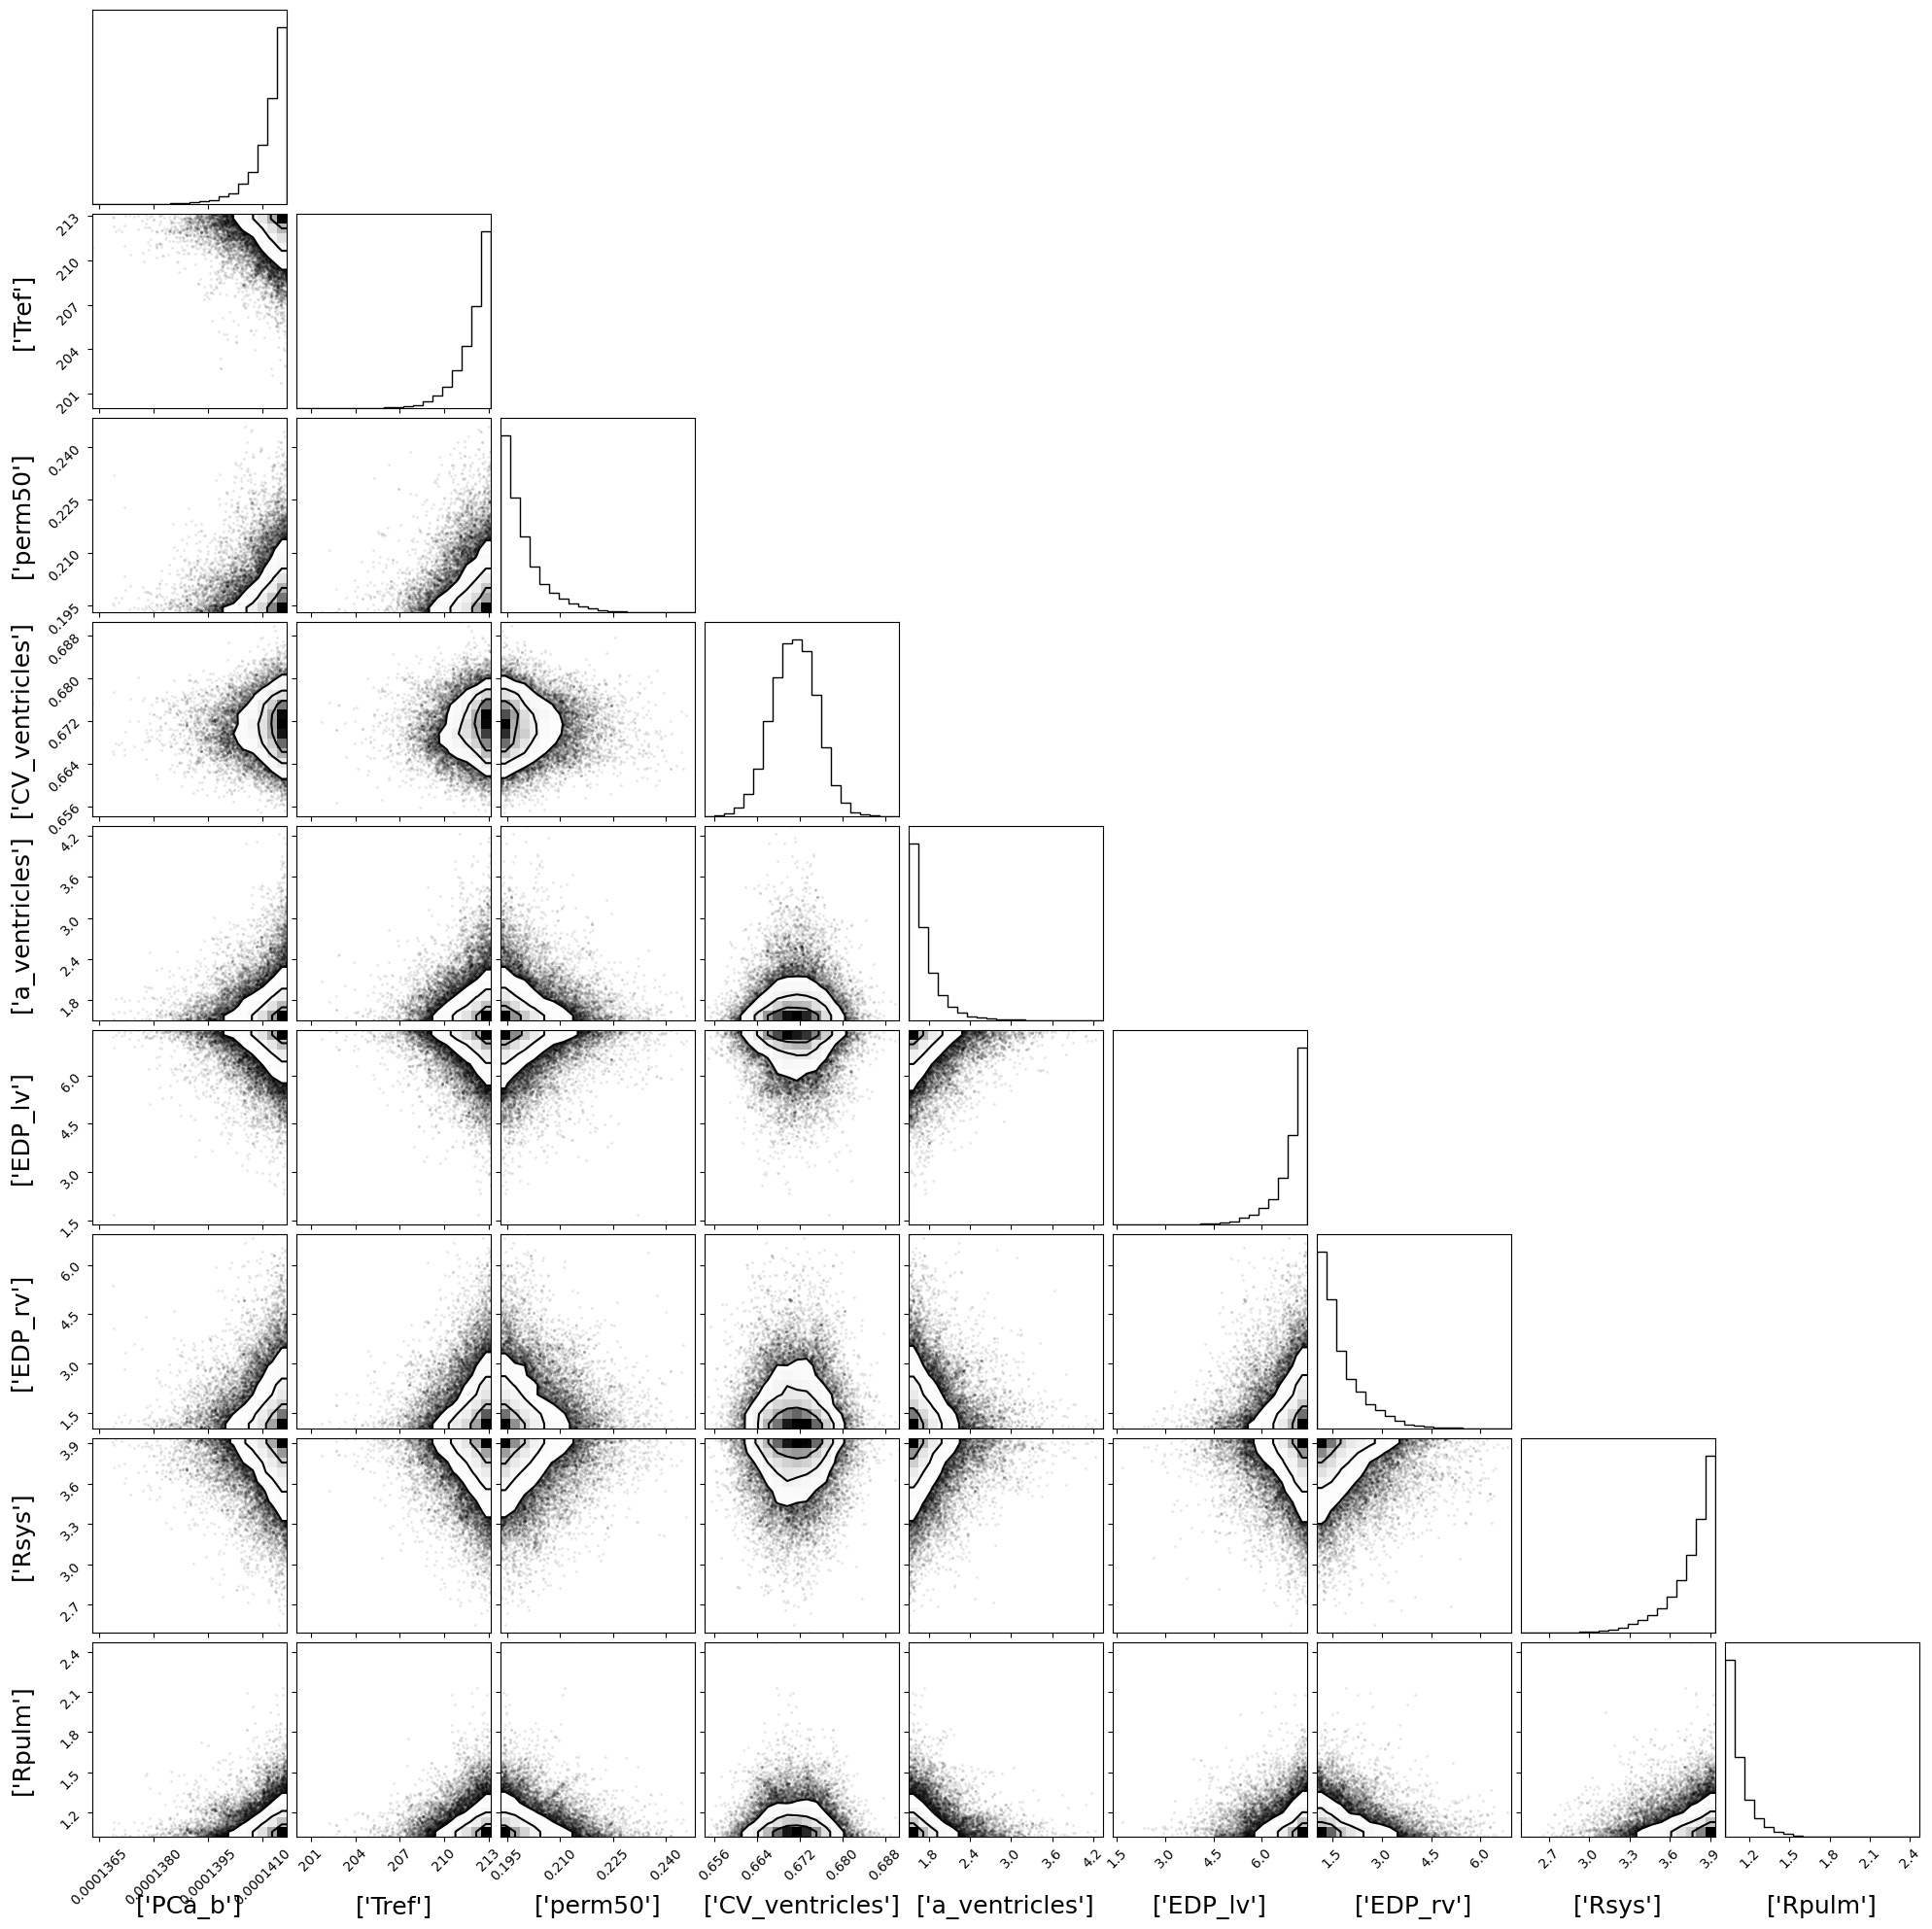

In [37]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

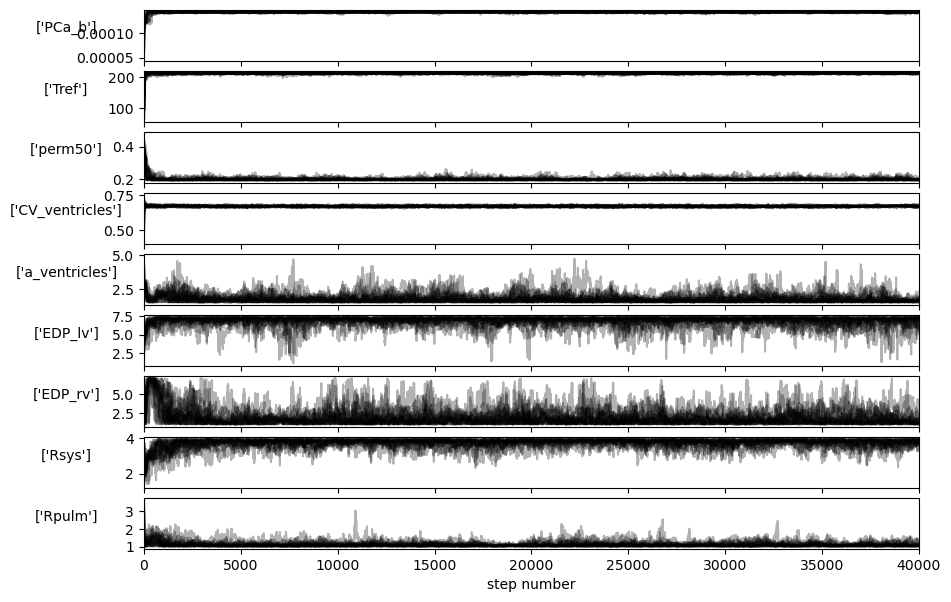

In [38]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [39]:
samp = pd.DataFrame(flat_samples).sample(50)

samp.to_csv("MCMC_samples_scenario_6_60.dat", sep = " ",index=False,header=None)

In [40]:
samp = pd.DataFrame(flat_samples)

samp.to_csv("MCMC_samples_scenario_6_60_full_posterior.dat", sep = " ",index=False,header=None)

In [41]:
torch.tensor(flat_samples.mean(axis=0))

tensor([1.4116e-04, 2.1195e+02, 1.9943e-01, 6.7099e-01, 1.7392e+00, 6.8940e+00,
        1.7667e+00, 3.7598e+00, 1.1161e+00], dtype=torch.float64)

In [42]:
pd.DataFrame(flat_samples).sample(50)

0           1         2         3         4         5         6  \
13106  0.000142  208.980874  0.195978  0.665136  1.646176  7.026798  1.613231   
20206  0.000141  209.849165  0.199781  0.665860  1.945819  7.375423  1.900852   
28292  0.000141  212.151809  0.201897  0.674809  1.583085  6.636781  1.307585   
20571  0.000141  212.485356  0.196941  0.667489  1.697151  7.160764  1.038774   
24337  0.000141  209.264863  0.223889  0.666636  2.356031  7.161783  2.141875   
8345   0.000141  212.654747  0.193446  0.673662  1.586464  5.793078  1.216460   
7808   0.000141  211.916242  0.197014  0.668507  1.892159  6.525185  1.539368   
3986   0.000140  213.081004  0.212626  0.675115  1.834959  6.769860  1.217543   
889    0.000142  212.327736  0.195204  0.670764  2.183372  6.916042  2.589182   
19845  0.000142  212.557408  0.197166  0.661917  1.534668  7.254080  1.339443   
10501  0.000141  211.046802  0.194639  0.667416  1.701880  7.401795  3.977058   
1495   0.000141  211.084252  0.193244  0.678492  1.874713  6.744815  1.331576   
14354  0.000141  211.154863  0.204281  0.669268  1.531300  7.245810  3.134914   
28661  0.000141  209.394362  0.193570  0.669982  1.855031  7.024110  1.255391   
7437   0.000142  211.911311  0.197260  0.666647  1.512770  7.048727  1.078107   
2553   0.000141  212.927906  0.196540  0.672456  2.158746  5.807275  2.821270   
11611  0.000141  211.092117  0.199757  0.677509  1.522774  6.890593  2.134853   
29672  0.000142  210.313197  0.194494  0.669029  1.690153  6.925884  1.220223   
28547  0.000141  213.027377  0.200412  0.670515  1.592009  6.205985  1.459927   
33731  0.000141  212.172294  0.194810  0.672319  1.522757  7.272900  1.770415   
12509  0.000141  212.906487  0.208843  0.663672  1.538408  6.912926  1.630735   
31329  0.000141  212.778069  0.198618  0.672459  1.836724  6.684645  1.285520   
33805  0.000141  211.984745  0.193299  0.678323  1.710379  7.274486  3.055764   
6732   0.000142  212.833246  0.196349  0.668437  1.542541  6.934186  1.486505   
391    0.000142  211.156712  0.194154  0.674170  1.613206  7.396423  3.054704   
3101   0.000141  212.650536  0.197819  0.673622  1.682742  7.081096  1.285789   
29555  0.000141  212.614430  0.195687  0.671315  1.605673  6.505795  2.138739   
35904  0.000141  212.748444  0.195006  0.665100  1.817550  6.936345  2.111265   
16415  0.000141  210.970950  0.205277  0.670488  2.093811  7.191324  1.440736   
15769  0.000141  212.480238  0.203972  0.674355  1.880820  7.219532  1.220365   
9080   0.000142  213.137314  0.201214  0.668411  1.568056  6.189002  1.289882   
17560  0.000141  210.817943  0.197744  0.676644  1.557530  7.393173  1.270382   
3379   0.000142  212.963776  0.193932  0.665557  1.537590  7.398171  3.372861   
20323  0.000142  212.471348  0.205748  0.666518  1.549893  5.360796  1.308526   
17974  0.000141  212.805465  0.194901  0.673429  1.587809  7.099413  1.177582   
7052   0.000141  211.604727  0.197758  0.670995  1.582956  6.723053  3.055436   
7577   0.000141  211.705861  0.193821  0.665342  2.147242  6.069411  1.495529   
16555  0.000142  212.152940  0.195119  0.665270  1.968962  7.349530  1.671814   
22829  0.000141  212.646438  0.213613  0.668036  1.517352  7.210339  3.622757   
7643   0.000141  212.811230  0.206103  0.665807  1.651099  6.409433  1.632270   
9256   0.000140  212.996548  0.193145  0.670500  2.065561  7.313846  1.628576   
26106  0.000141  211.599425  0.193658  0.661106  1.540303  6.714030  1.756995   
5937   0.000141  213.123942  0.194085  0.670923  2.493060  7.242567  1.521145   
11041  0.000141  212.381799  0.195117  0.670458  1.518314  7.304414  4.142131   
35283  0.000141  211.014615  0.202035  0.675653  1.615248  6.913805  1.660155   
8587   0.000141  208.175695  0.201392  0.669577  1.635763  7.374793  1.159099   
23441  0.000140  212.538764  0.208671  0.675135  1.886706  7.223637  1.320025   
34518  0.000141  212.122632  0.193205  0.672358  1.581686  4.572833  1.200366   
26716  0.000141  210.791793  0.194706  0.6743

In [43]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None,:])

tensor([[ 99.9134, 121.5967,   0.4253]], grad_fn=<PermuteBackward0>)

# Scenario 8

     CV_ventricles  CV_atria  a_ventricles  a_atria   EDP_lv   EDP_rv  \
0         0.726590  1.027220       4.55728  3.68805  6.30434  6.88496   
1         0.447083  0.665930       4.77565  3.37159  7.40547  6.83182   
2         0.718076  0.322269       3.44083  4.10285  6.99799  1.66170   
3         0.743881  0.633801       3.00760  3.08643  2.90710  5.82416   
4         0.711816  0.537416       3.20078  2.19295  6.15502  3.05678   
..             ...       ...           ...      ...      ...      ...   
995       0.545563  0.483369       2.31175  3.96805  4.79704  6.54769   
996       0.787014  0.780854       3.06559  4.27542  6.57854  4.39223   
997       0.628652  0.443699       1.28976  4.76784  5.42560  4.53470   
998       0.728018  0.455842       2.92803  2.80237  1.76374  5.95269   
999       0.406376  0.867252       1.55451  3.02115  3.78612  5.67230   

        Rsys    Rpulm  
0    2.55691  2.51360  
1    2.99569  3.10845  
2    1.72819  3.97452  
3    2.13610  2.51762  
4  

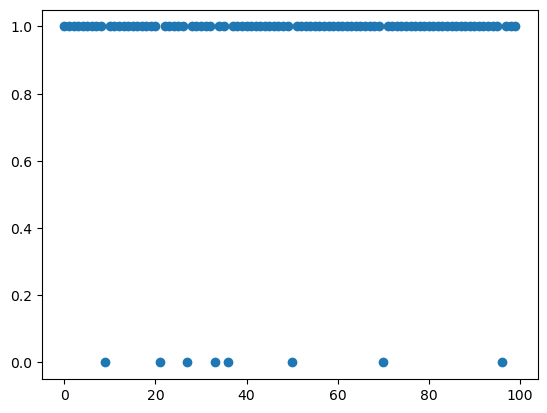

In [44]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [45]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [46]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382501, 0.796001]
[0.3052, 1.0282]
[1.03409, 4.99708]
[1.25589, 4.9957]
[1.15984, 7.49807]
[1.15945, 7.45172]
[1.04163, 3.9583]
[1.00422, 3.97892]


In [47]:
x_all = torch.tensor(input_masked.values)

y_calibration = y_all.loc[:,['A_TAT','V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





In [48]:
y_max=y_calibration.max(axis=0)

In [49]:
y_max

torch.return_types.max(
values=tensor([ 98.5870, 121.6470, 110.5000,   0.3867], dtype=torch.float64),
indices=tensor([44,  6, 82, 37]))

In [80]:
y_test = y_calibration[y_max[1][3],:]
x_test = x_all[y_max[1][3],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


In [81]:
emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3


In [82]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test
obs_error=torch.tensor([0.1,0.1,0.1,0.001])

In [83]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [84]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-23.977901458740234
-11.900806427001953
-0.7717034816741943
-283.8245849609375
-9.626203536987305
-9.547636032104492
-298.8589172363281
-12.637561798095703
-11.208327293395996
-8.659759521484375
-738.0363159179688
-376.685302734375
-263.6092224121094
-669.82958984375
-307.5577697753906
-542.25341796875
-720.7655639648438
-269.5792236328125


In [85]:
sampler.run_mcmc(p0, 40000)

State([[0.71319544 0.8060418  3.68018837 5.91121567 3.52278785 1.72765338
  2.89200448]
 [0.50577921 0.47592436 3.54278264 6.59212279 3.32114663 2.08290726
  2.26033128]
 [0.40322358 0.37398634 2.94467866 4.68000213 3.51801707 2.55916319
  2.51449788]
 [0.45134081 0.9351667  3.61331115 6.79951645 3.36283711 2.26432359
  2.36031653]
 [0.58045296 0.71604135 3.9148163  7.04727029 3.84172168 2.15959071
  1.6415211 ]
 [0.77221987 0.64474697 3.13429196 6.72250748 2.62661562 1.82533741
  1.53461905]
 [0.46099062 0.38922234 4.57901463 6.93489572 3.66727847 1.7693996
  2.83675679]
 [0.68896918 0.91349814 4.54617772 6.07243621 3.41729214 1.90807622
  3.84799366]
 [0.45204762 0.79781345 3.95759034 6.7259099  3.70683178 3.46525429
  1.88924458]
 [0.59294049 0.59901744 3.74650095 6.18177088 3.54214835 2.40404543
  1.67611429]
 [0.60956818 0.43831423 2.74742777 6.80477636 3.6190039  3.59640907
  2.16055601]
 [0.76224382 0.70922521 4.5941959  7.2548152  2.23382211 1.87372939
  1.88875384]
 [0.5777321

In [86]:
flat_samples = sampler.get_chain(discard=20, thin=10, flat=True)
print(flat_samples.shape)

(71964, 7)


In [87]:
x_test

tensor([0.5967, 0.9513, 3.0979, 7.1980, 2.3953, 1.4168, 1.6362],
       dtype=torch.float64)

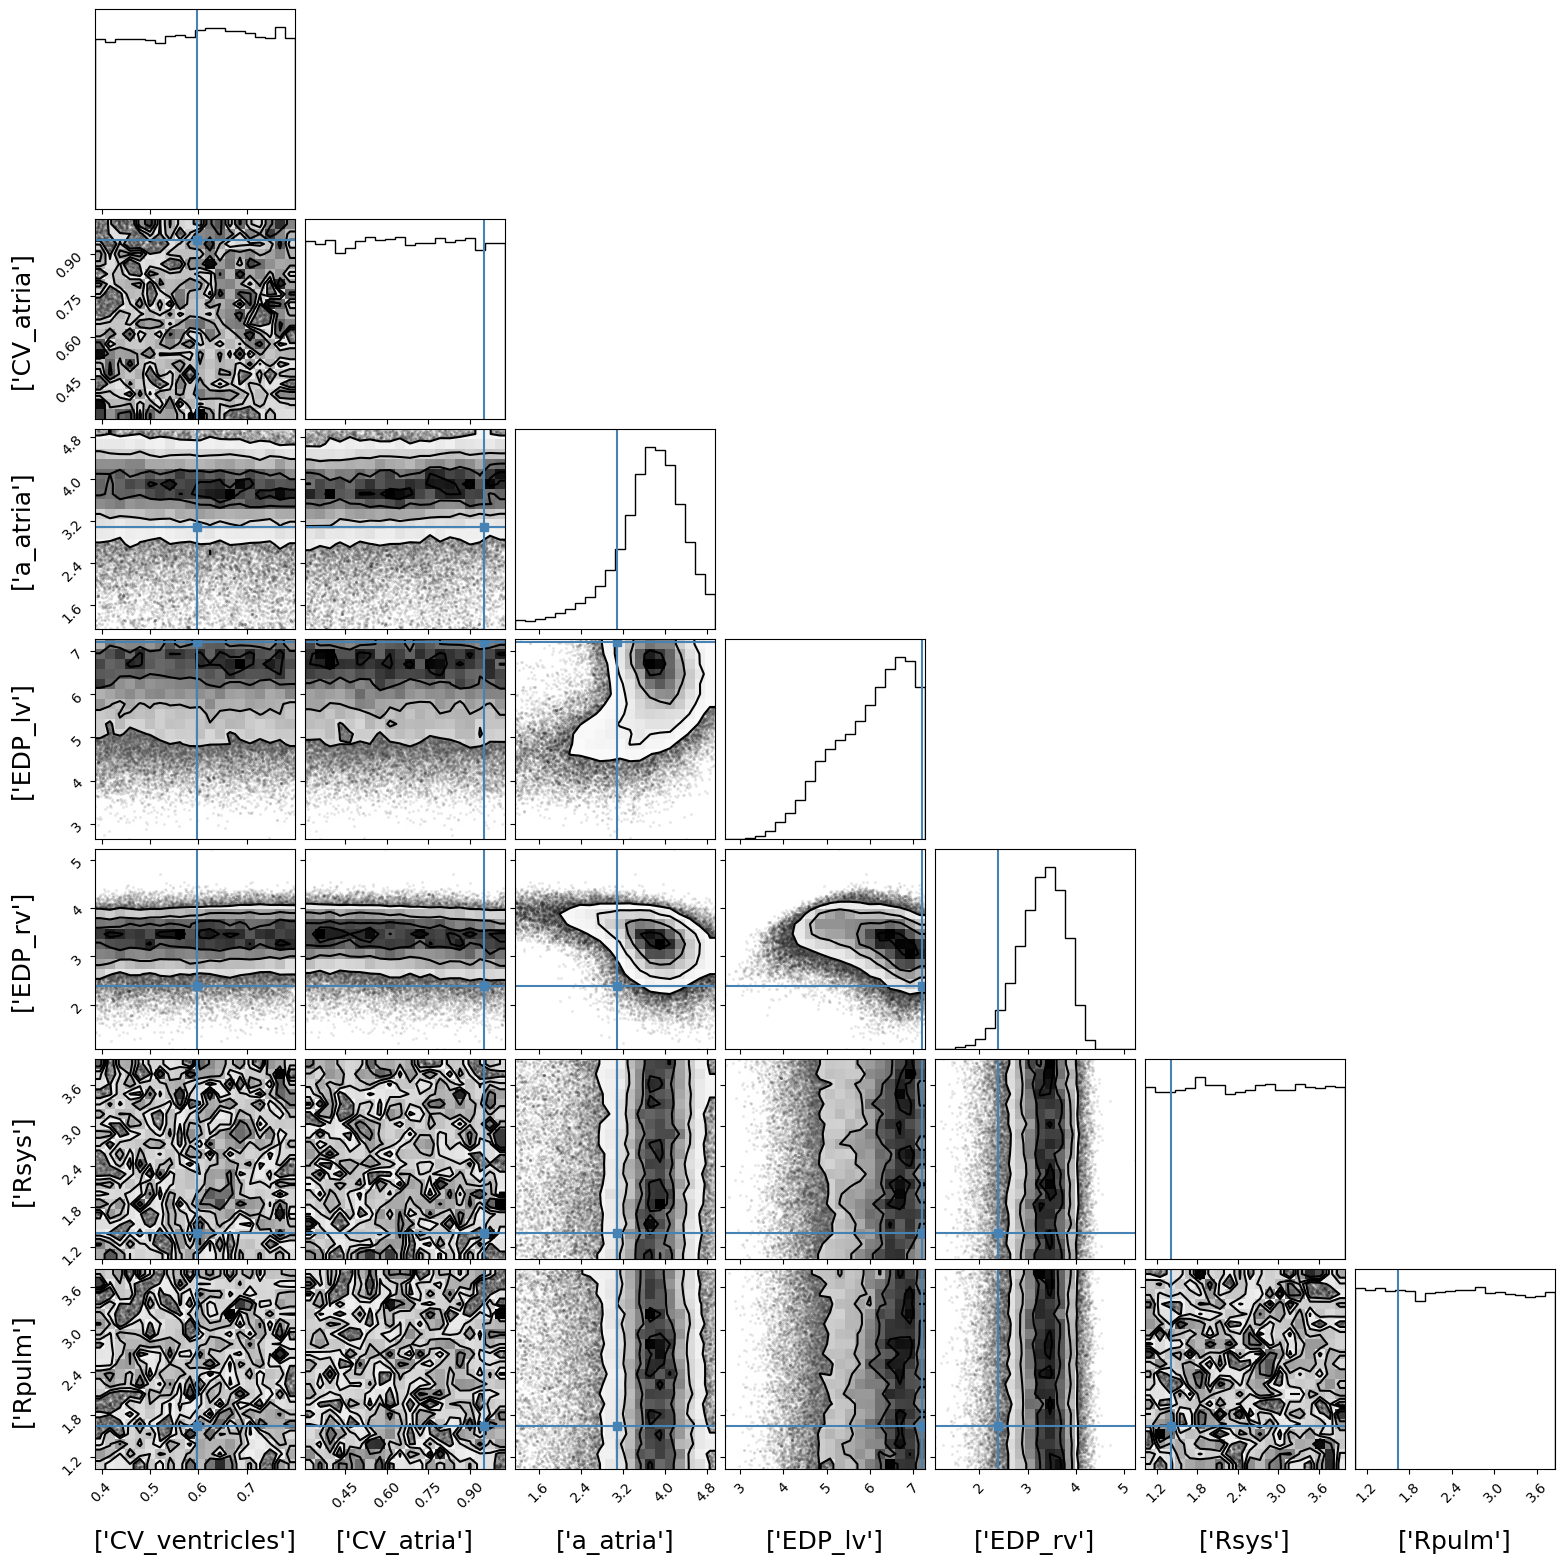

In [88]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

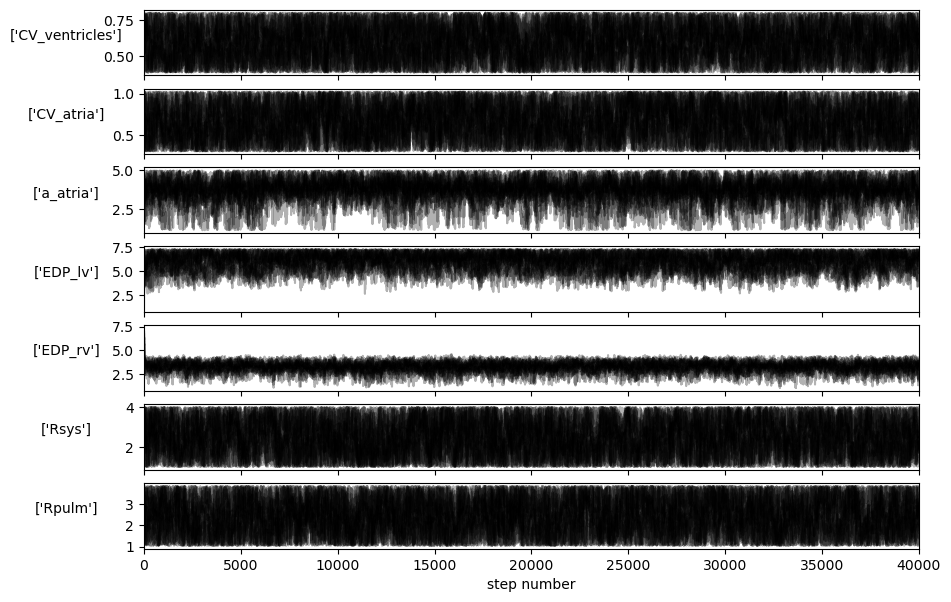

In [89]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [90]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2
3


In [91]:
y_val = torch.tensor([134,80,133,0.6])
obs_error=torch.tensor([0.1,10,0.1,0.001])

In [92]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [93]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-8595.6953125
-7805.37548828125
-8678.9140625
-10522.14453125
-6672.18798828125
-5152.45068359375
-8870.529296875
-8318.1162109375
-8571.791015625
-8749.5166015625
-8785.447265625
-7791.564453125
-8597.7119140625
-9560.591796875
-8239.7138671875
-10563.9560546875
-8916.8623046875
-10385.37109375


In [64]:
sampler.run_mcmc(p0, 40000)

State([[0.79115117 0.43062129 1.0341633  4.98641699 5.97217639 2.18355249
  1.23504803 3.97615922]
 [0.79598313 0.30555563 1.42159543 3.55856474 1.16024672 1.77409581
  1.93496052 2.7333149 ]
 [0.79123975 0.41779353 1.03509602 4.95682809 5.85368582 2.11840752
  1.22706753 3.97709564]
 [0.78963442 0.42718633 1.03479059 4.9897769  5.81837543 2.14436754
  1.23638869 3.97648081]
 [0.79371839 0.3052122  1.03451892 1.25608796 4.49014482 1.36184614
  1.38826935 1.02424635]
 [0.3825477  0.36885706 1.31202493 4.99506906 7.49010564 2.70985033
  2.62699276 1.47906292]
 [0.7939707  0.30541001 1.03684911 1.25626045 4.48903028 1.36605162
  1.38824668 1.02523228]
 [0.79556286 0.30525015 1.42316276 3.5576645  1.16050115 1.77609065
  1.93388357 2.73333396]
 [0.40634036 0.50890414 3.77393346 4.88369826 3.08843849 6.5009815
  1.0416697  2.34474568]
 [0.61360499 0.6790348  4.37670917 3.31364134 1.16048175 2.20896741
  3.53123096 3.97885821]
 [0.38384564 0.37033965 1.30336193 4.99473377 7.49636271 2.720244

In [65]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 8)


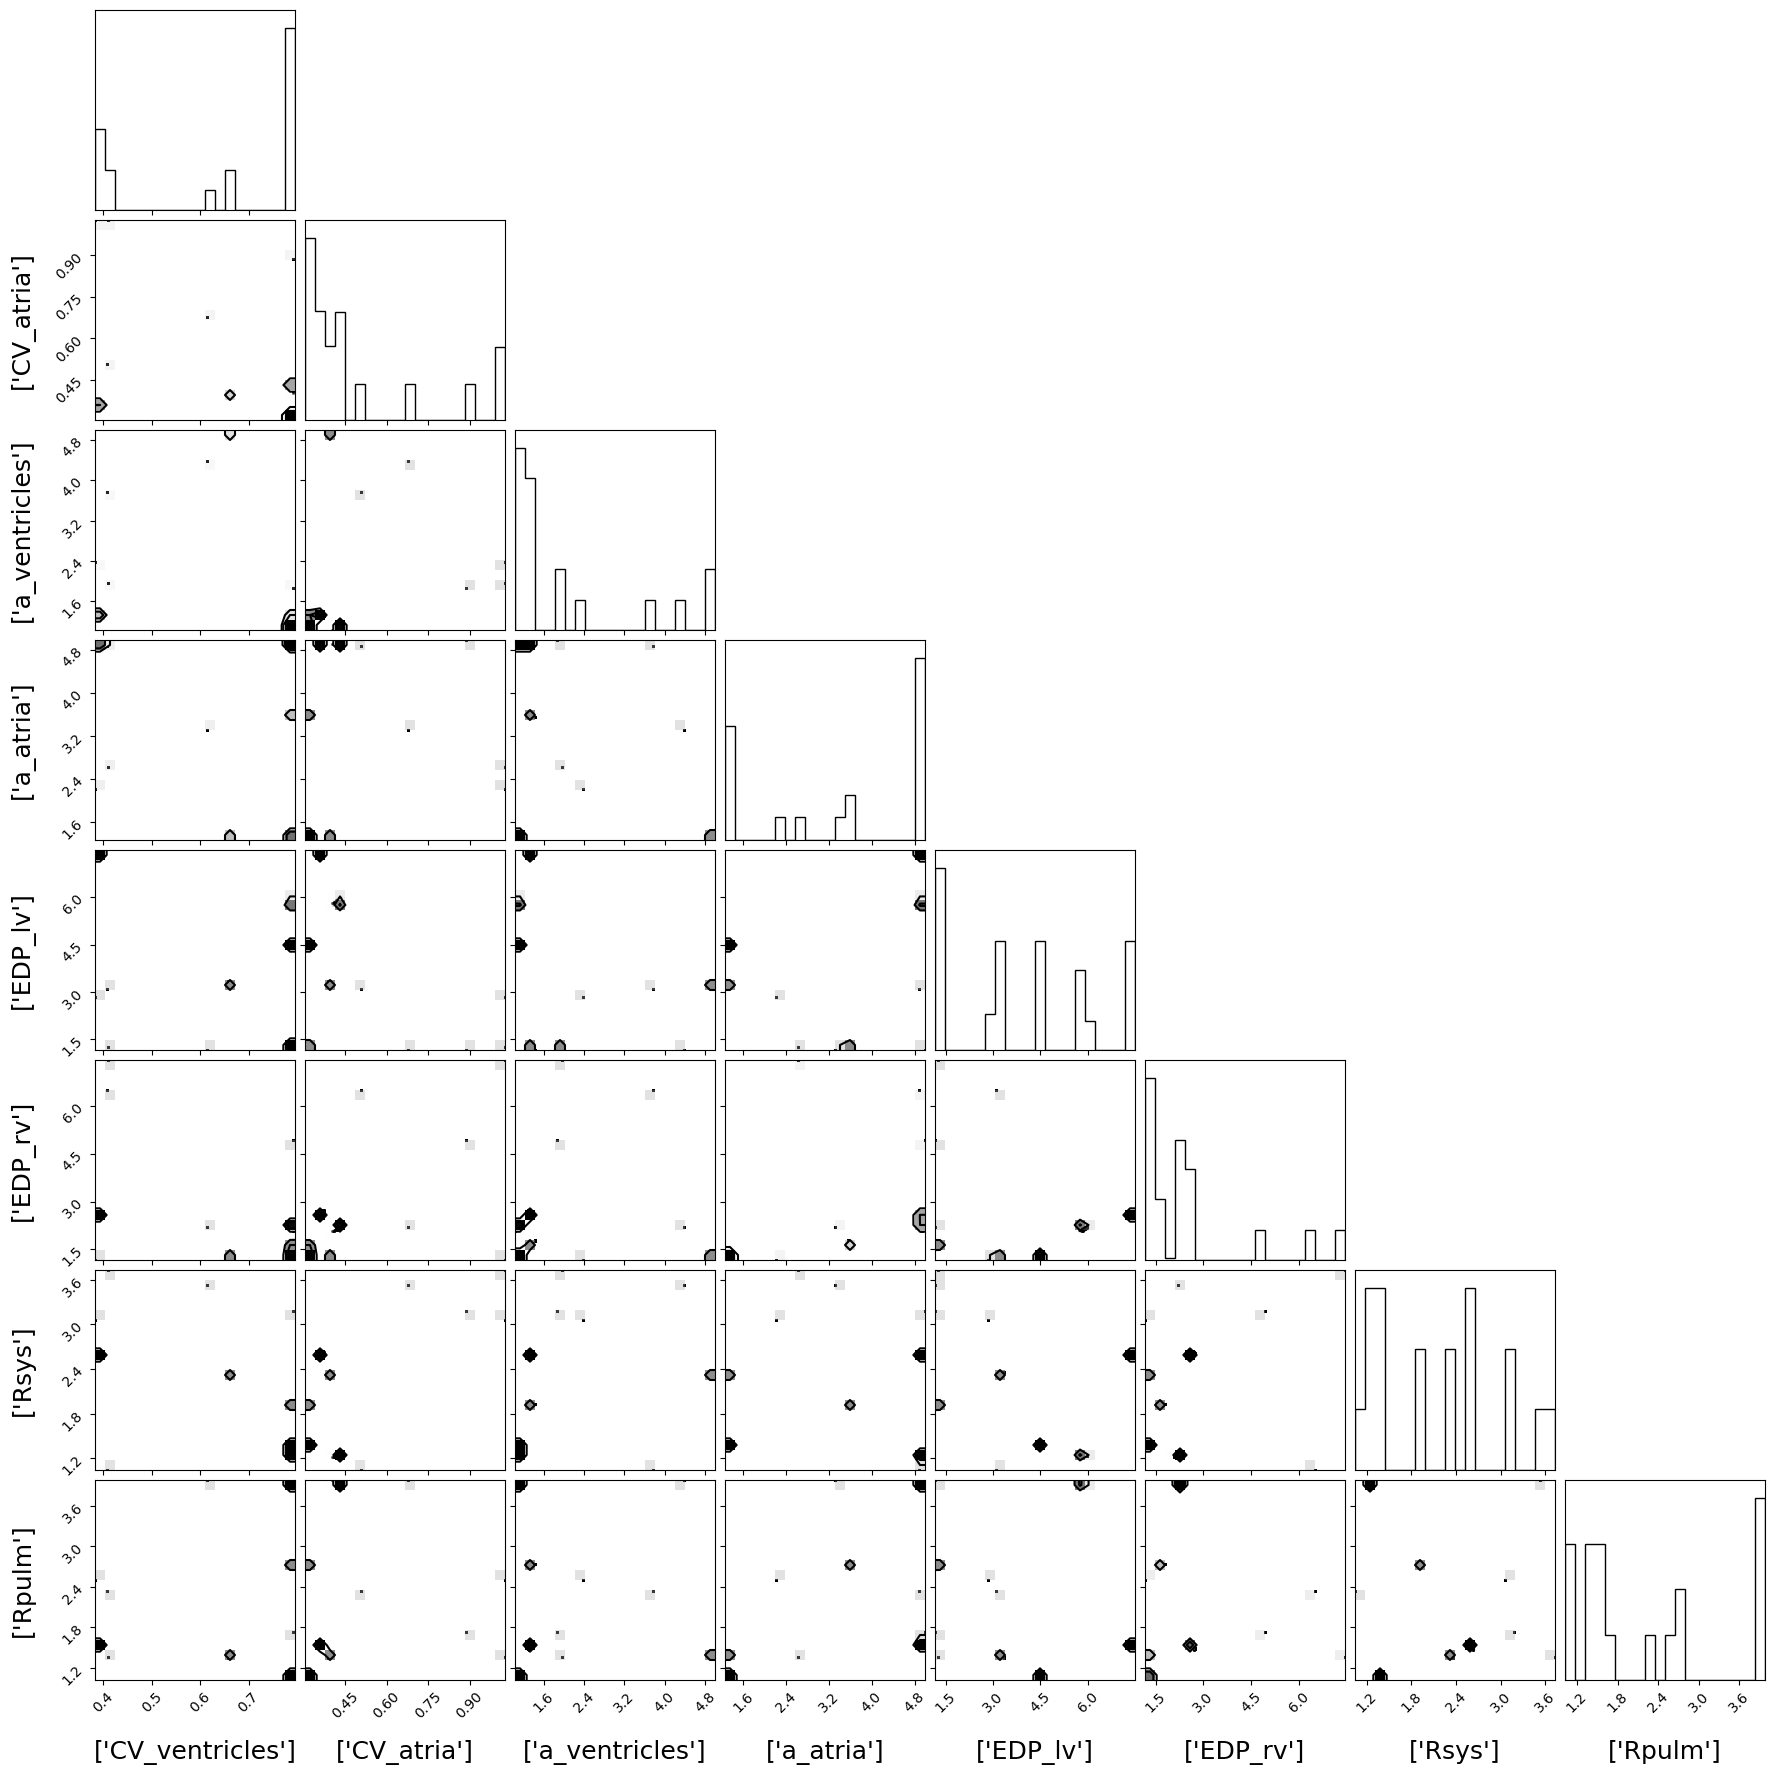

In [66]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

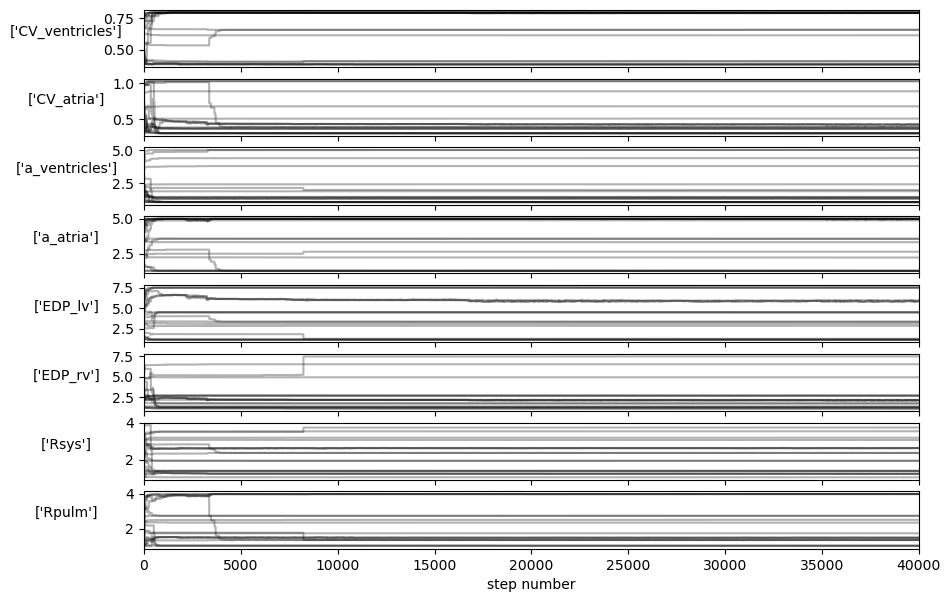

In [67]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Scenario 9

     CV_ventricles  CV_atria  a_atria   EDP_lv   EDP_rv     Rsys    Rpulm
0         0.583426  0.559737  2.63999  3.00130  4.86389  2.62436  1.74940
1         0.513584  0.679305  3.15695  5.65473  6.89338  2.07232  3.77998
2         0.528843  0.596498  4.85812  5.02497  2.16558  1.34170  2.09279
3         0.576382  0.320044  2.30249  3.45923  3.79267  1.44626  3.62270
4         0.706760  0.986539  1.47919  2.71888  3.53382  3.55907  3.37904
..             ...       ...      ...      ...      ...      ...      ...
995       0.492465  0.433849  3.11757  1.13969  5.68550  2.69079  1.14159
996       0.693082  0.775705  3.06761  3.16270  5.87700  2.03175  3.11116
997       0.383862  0.422026  3.75881  2.76191  7.32266  2.90629  2.73541
998       0.391658  0.580093  3.14632  7.38027  6.52224  3.83890  1.65956
999       0.488805  0.328415  4.39081  5.60215  1.67397  1.75135  3.87967

[1000 rows x 7 columns]
     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   170.37   

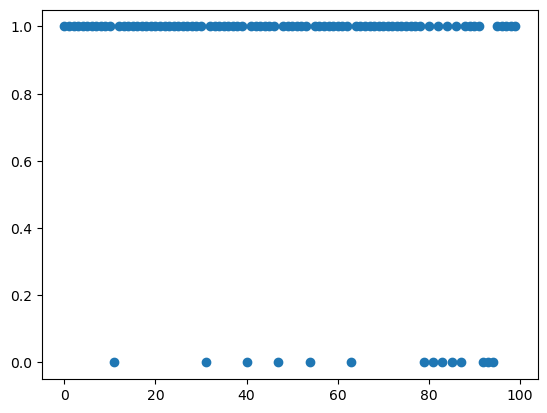

In [71]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [72]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [73]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.386498, 0.799253]
[0.305504, 1.02567]
[1.1476, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]
[1.02992, 3.98405]
[1.03672, 3.85692]


In [74]:
x_all = torch.tensor(input_masked.values)

y_calibration = y_all.loc[:,['A_TAT','V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





In [75]:
y_max=y_calibration.max(axis=0)

In [76]:
y_max

torch.return_types.max(
values=tensor([ 98.1420, 120.4430, 110.3900,   0.3682], dtype=torch.float64),
indices=tensor([10, 28, 26, 72]))

In [77]:
y_test = y_calibration[y_max[1][3],:]
x_test = x_all[y_max[1][3],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


In [78]:
emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3


In [79]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test
obs_error=torch.tensor([0.1,0.1,0.1,0.001])

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=20, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
x_test

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

In [ ]:
y_val = torch.tensor([134,80,133,0.6])
obs_error=torch.tensor([0.1,10,0.1,0.001])

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [3]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [4]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

# Scenario 10

     CV_ventricles  CV_atria  a_atria   EDP_lv   EDP_rv     Rsys    Rpulm
0         0.583426  0.559737  2.63999  3.00130  4.86389  2.62436  1.74940
1         0.513584  0.679305  3.15695  5.65473  6.89338  2.07232  3.77998
2         0.528843  0.596498  4.85812  5.02497  2.16558  1.34170  2.09279
3         0.576382  0.320044  2.30249  3.45923  3.79267  1.44626  3.62270
4         0.706760  0.986539  1.47919  2.71888  3.53382  3.55907  3.37904
..             ...       ...      ...      ...      ...      ...      ...
995       0.492465  0.433849  3.11757  1.13969  5.68550  2.69079  1.14159
996       0.693082  0.775705  3.06761  3.16270  5.87700  2.03175  3.11116
997       0.383862  0.422026  3.75881  2.76191  7.32266  2.90629  2.73541
998       0.391658  0.580093  3.14632  7.38027  6.52224  3.83890  1.65956
999       0.488805  0.328415  4.39081  5.60215  1.67397  1.75135  3.87967

[1000 rows x 7 columns]
     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   167.78   

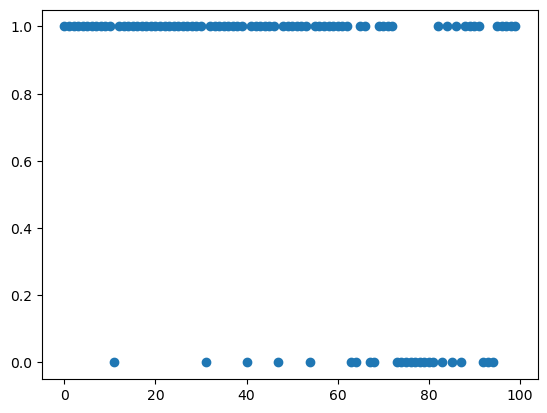

In [94]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [95]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [96]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.386498, 0.799253]
[0.305504, 1.02567]
[1.47919, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]
[1.02992, 3.98405]
[1.03672, 3.85692]


In [97]:
x_all = torch.tensor(input_masked.values)

y_calibration = y_all.loc[:,['A_TAT','V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





In [98]:
y_max=y_calibration.max(axis=0)

In [99]:
y_max

torch.return_types.max(
values=tensor([286.0400, 161.4530, 117.5800,   0.4480], dtype=torch.float64),
indices=tensor([20, 41, 58, 54]))

In [100]:
y_test = y_calibration[y_max[1][3],:]
x_test = x_all[y_max[1][3],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


In [101]:
emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3


In [102]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test
obs_error=torch.tensor([0.1,0.1,0.1,0.001])

In [103]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [104]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-8789.09765625
-1823.545166015625
-1314.372802734375
-7507.8701171875
-1020.6851806640625
-848.600341796875
-6590.328125
-3341.650390625
-2377.625
-4996.27294921875
-1453.586181640625
-636.6817626953125
-949.5009155273438
-2380.8408203125
-3718.91015625
-9613.1591796875
-3146.4296875
-1461.969970703125


In [105]:
sampler.run_mcmc(p0, 40000)

State([[0.67971407 0.60705986 4.46508052 5.9962026  3.84544374 1.09635996
  1.97647475]
 [0.67847378 0.60193278 2.43086252 2.50798611 2.48518881 1.11320374
  1.90309366]
 [0.68349817 0.59596795 2.1407667  3.76769693 3.73125696 1.05409111
  1.84193599]
 [0.6797951  0.59079767 1.74079865 5.94378317 1.92847619 1.25544276
  3.38022321]
 [0.67893734 0.59916129 3.11408268 6.17698944 3.32821704 1.42210693
  3.14481048]
 [0.68548255 0.60568259 4.54019413 5.23859731 4.71978616 1.09235559
  1.51386904]
 [0.67701858 0.59924191 3.93017839 5.00981172 2.29998097 1.46243146
  3.54709916]
 [0.69372389 0.59803859 1.5646193  3.64231652 5.01829412 1.21719754
  1.79761524]
 [0.67435236 0.59556032 1.87135664 4.70374282 1.20039854 1.03784832
  2.56593287]
 [0.6886963  0.59573208 3.17691721 5.77594174 5.04564772 1.34846889
  2.60472884]
 [0.6925162  0.59054216 1.80621835 7.18399482 6.2217788  1.41263117
  2.262513  ]
 [0.68447994 0.59433583 2.31568681 6.65990256 4.72481935 1.28272584
  2.50199959]
 [0.674646

In [106]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

(54000, 7)


In [107]:
x_test

tensor([0.6751, 0.5995, 3.3951, 4.2870, 2.1879, 1.1464, 2.5336],
       dtype=torch.float64)

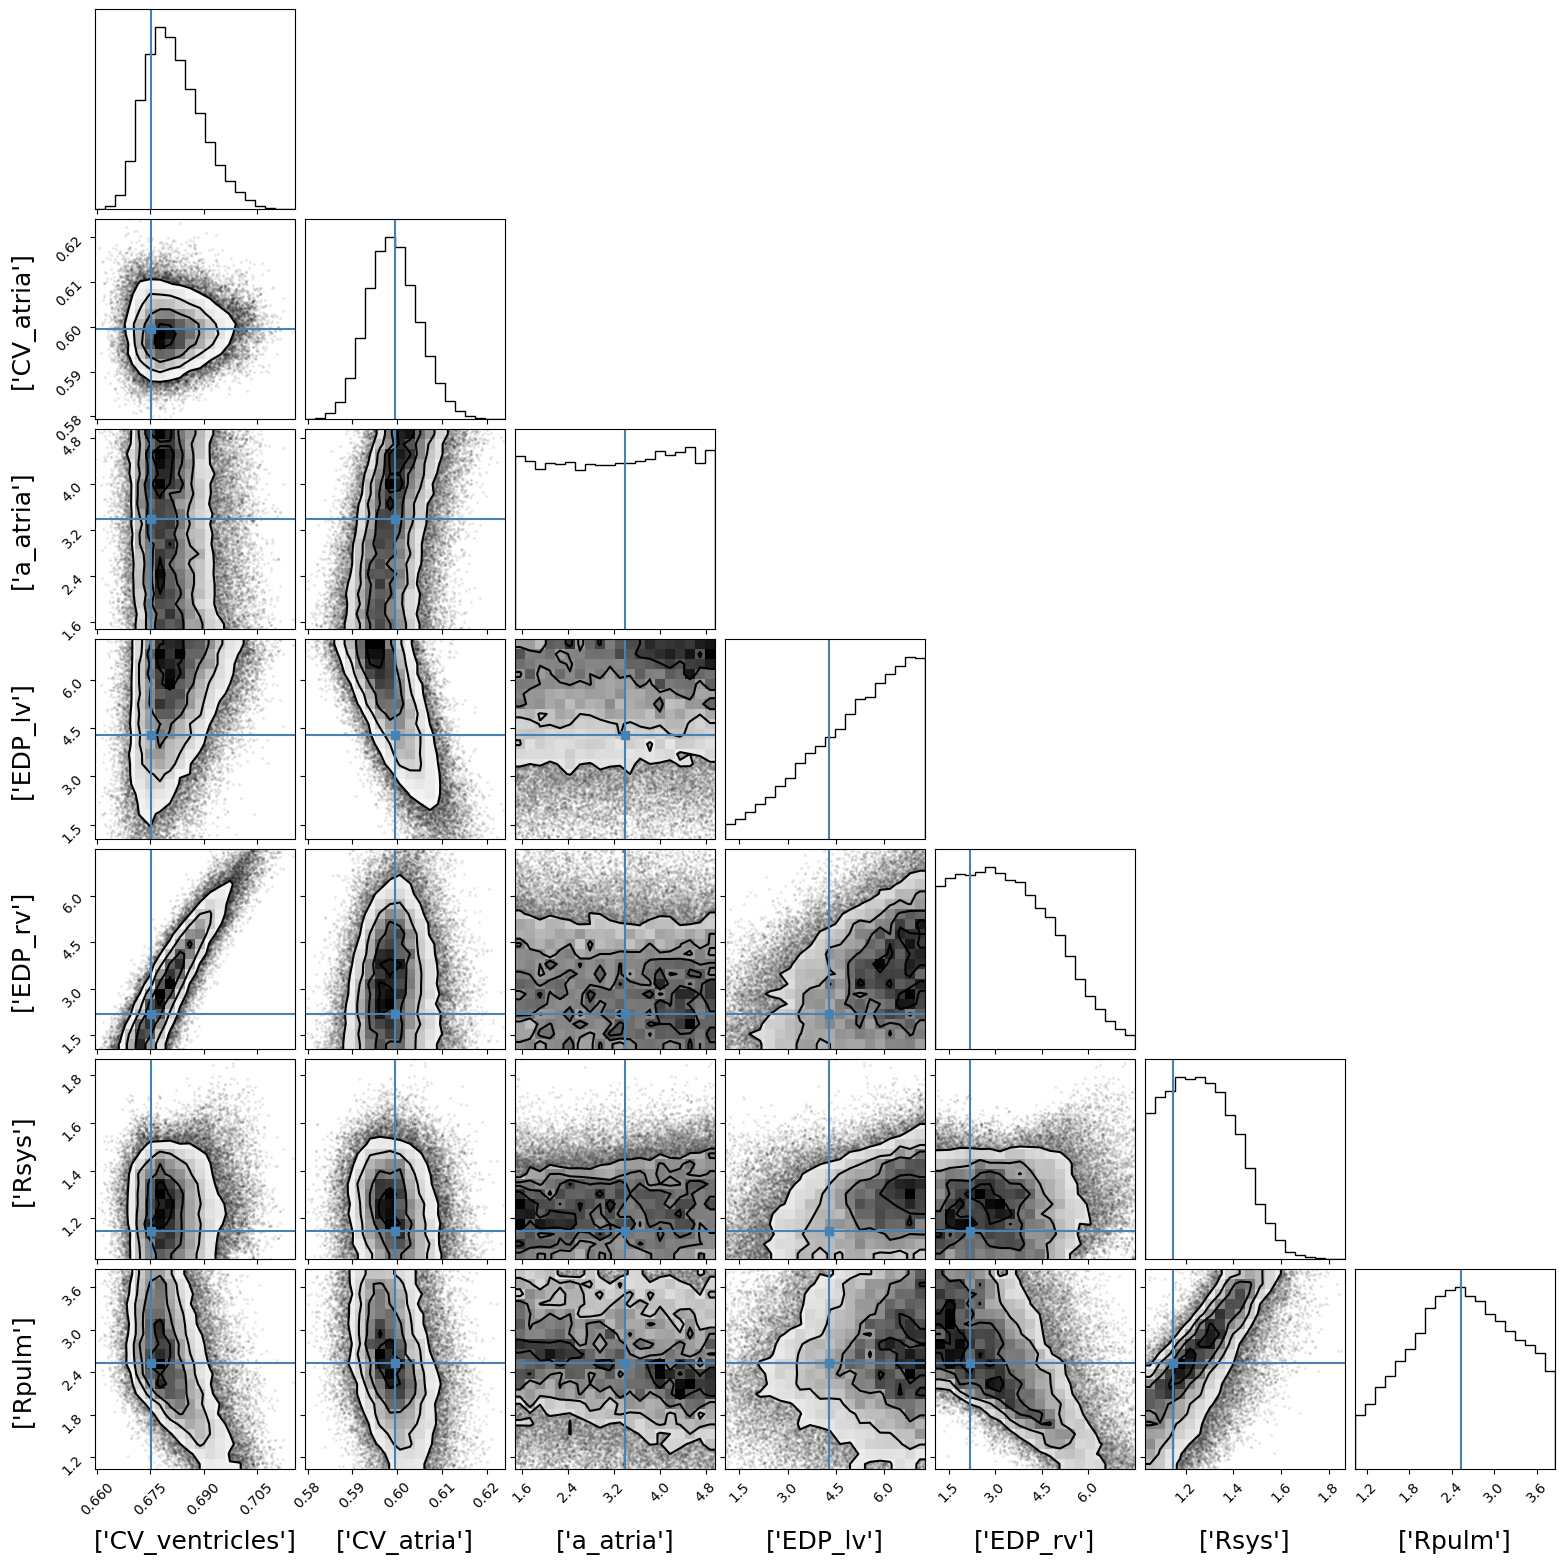

In [108]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

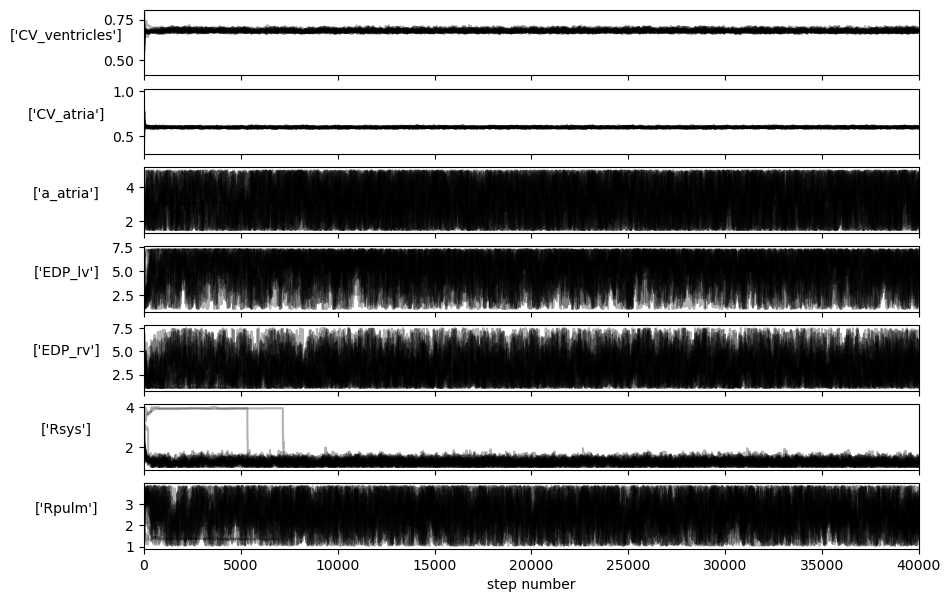

In [109]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [112]:
samp = pd.DataFrame(flat_samples).sample(50)

samp.to_csv("MCMC_samples_scenario_10_40.dat", sep = " ",index=False,header=None)

In [113]:
samp = pd.DataFrame(flat_samples)

samp.to_csv("MCMC_samples_scenario_10_40_full_posterior.dat", sep = " ",index=False,header=None)

In [114]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2
3


In [115]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_33021/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [116]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000041  0.000008
(CV_atria,)       0.997021  0.066129
(a_atria,)        0.000036  0.000006
(EDP_lv,)         0.000819  0.000079
(EDP_rv,)         0.000236  0.000024
(Rsys,)           0.000011  0.000002
(Rpulm,)          0.000010  0.000001
                        S1   S1_conf
(CV_ventricles,) -0.000035  0.000635
(CV_atria,)       0.997203  0.090630
(a_atria,)        0.000071  0.000479
(EDP_lv,)         0.000620  0.002731
(EDP_rv,)         0.000189  0.001400
(Rsys,)           0.000015  0.000336
(Rpulm,)          0.000047  0.000261
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                            ST       ST_conf
(CV_ventricles,)  9.949586e-01  6.089413e-02
(CV_atria,)       4.256825e-05  7.412126e-06
(a_atria,)        2.410457e-05  4.220007e-06
(EDP_lv,)         7.455645e-06  1.040574e-06
(EDP_rv,)         5.005850e-03  4.515524e-04
(Rsys,)           2.862452e-06  3.295980e-07
(Rpulm,)          4.839648e-07  6.296951e-08

In [117]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

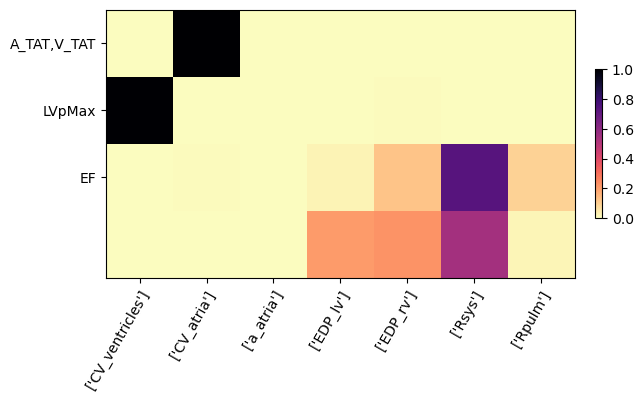

In [118]:
inputs = x_labels.values.tolist()
outputs = ['A_TAT,''V_TAT','LVpMax','EF']
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [119]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = torch.tensor([134,100,133,0.6])
obs_error=torch.tensor([0.1,0.1,0.1,0.001])

In [120]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [121]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-2137.889892578125
-9805.021484375
-4176.990234375
-11854.6181640625
-8204.21484375
-1964.8193359375
-6292.86962890625
-6175.552734375
-6161.39990234375
-6372.458984375
-4449.01416015625
-7517.18603515625
-3639.066162109375
-11939.5048828125
-1025.3885498046875
-5260.17138671875
-2666.480712890625
-4026.98095703125


In [122]:
sampler.run_mcmc(p0, 40000)

State([[0.60360528 0.62275944 1.54187086 6.99636409 1.58001829 3.95136261
  1.2194924 ]
 [0.60484641 0.62505166 1.48942636 7.17011562 1.2598013  3.96090635
  1.19689887]
 [0.60164685 0.63793082 1.76073213 7.23071537 1.13239896 3.96039151
  1.05109302]
 [0.60764705 0.62132083 1.53304037 6.46973112 1.19080309 3.92861412
  1.09299336]
 [0.60557271 0.63017072 2.89031007 6.93643316 1.11110004 3.94915144
  1.08646759]
 [0.6031786  0.63284928 2.76682712 7.23527661 1.19846956 3.93961515
  1.05260874]
 [0.60899601 0.62608804 1.77453412 7.15464291 1.45297518 3.9262089
  1.0505041 ]
 [0.60214654 0.63132209 2.19373085 7.2140538  1.34788376 3.97662003
  1.0452938 ]
 [0.60057949 0.63720293 2.79551576 6.98351375 1.13797714 3.92507943
  1.1358468 ]
 [0.60974205 0.62340362 2.32530682 7.10095078 1.30201199 3.98058765
  1.04449422]
 [0.60253446 0.6295918  1.73463703 6.57483429 1.25517343 3.88992028
  1.08034296]
 [0.60259285 0.62592578 1.58063403 7.15175442 1.23222297 3.92646137
  1.06995476]
 [0.6011921

In [123]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 7)


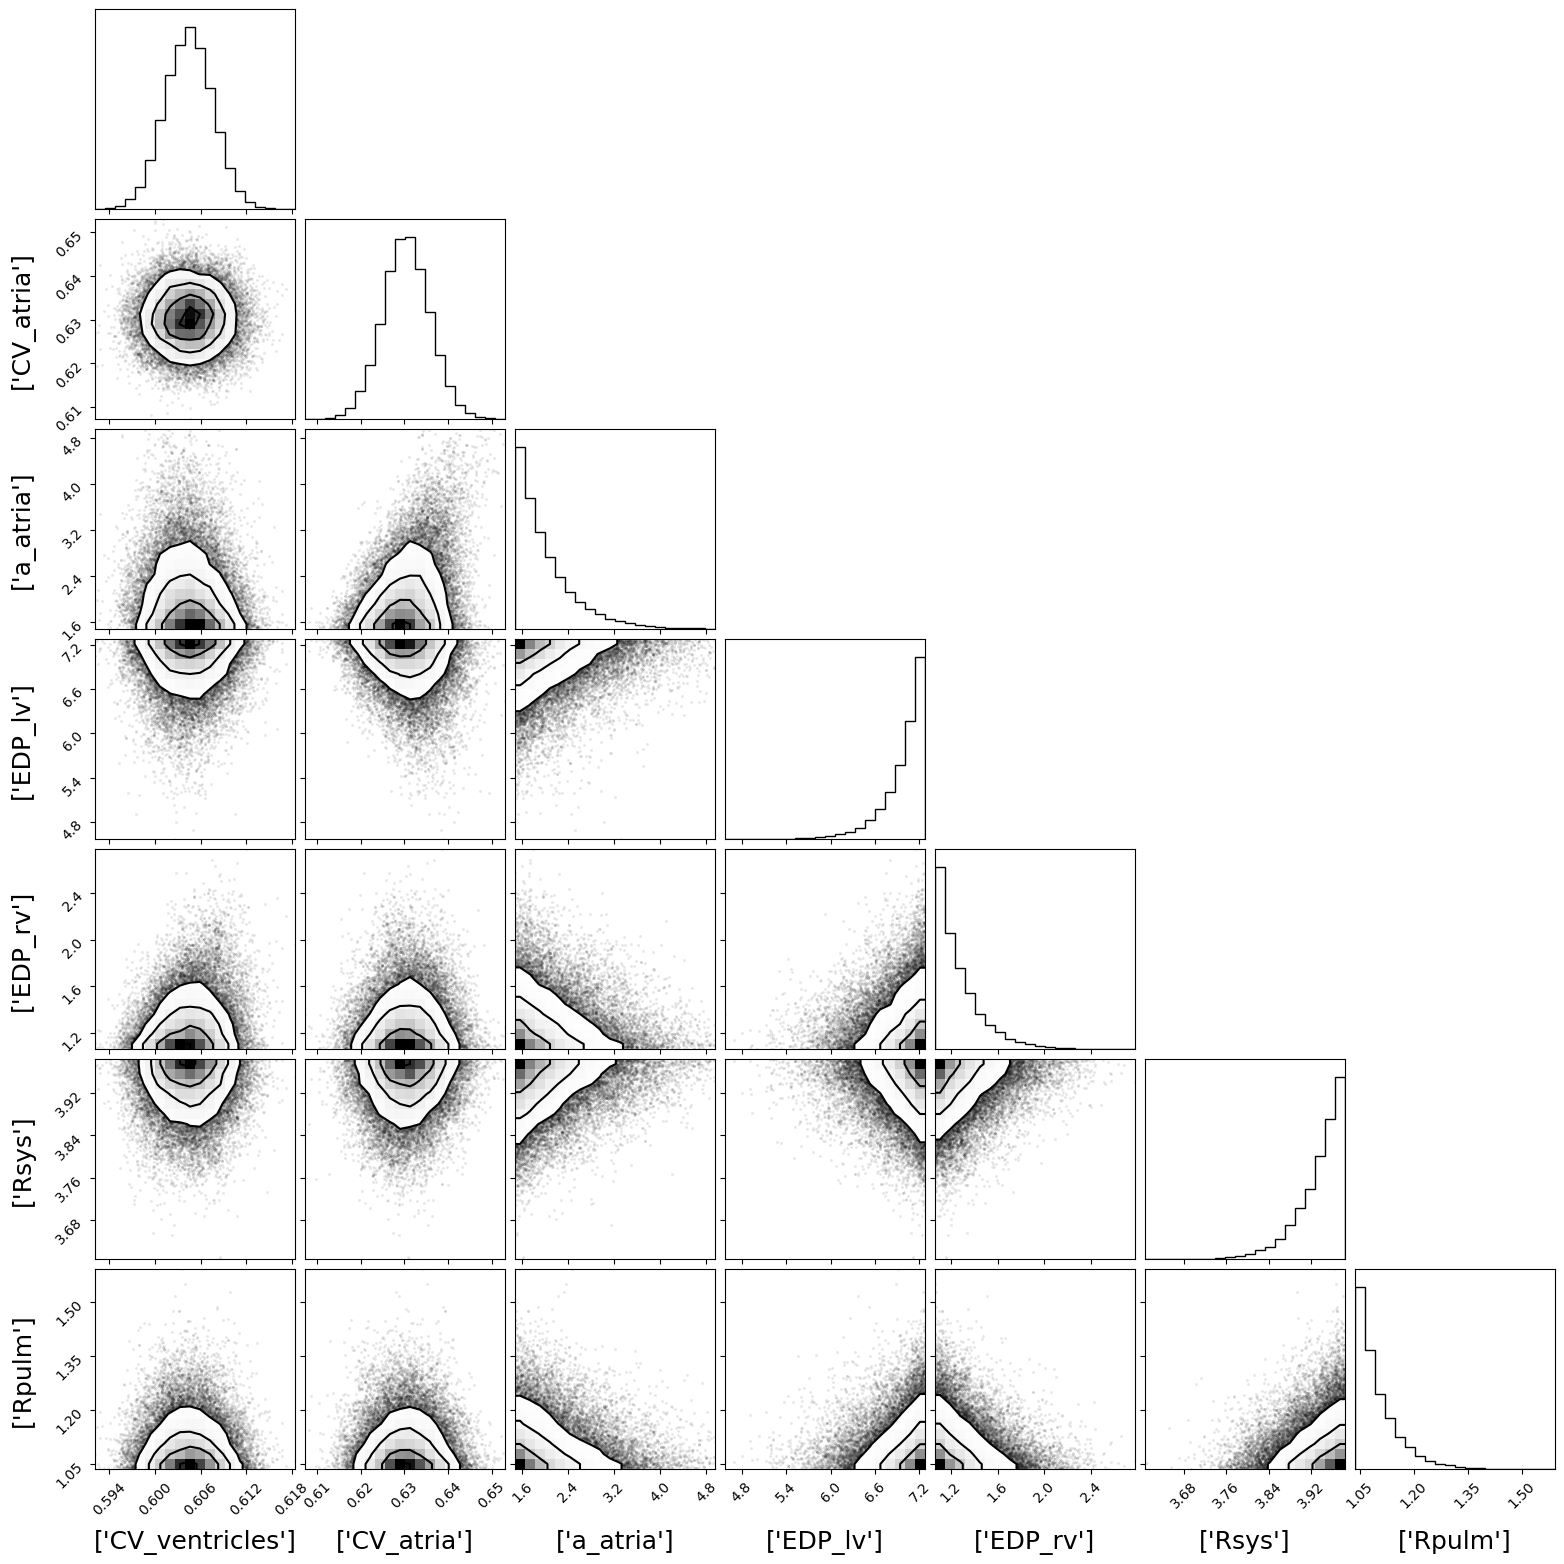

In [124]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

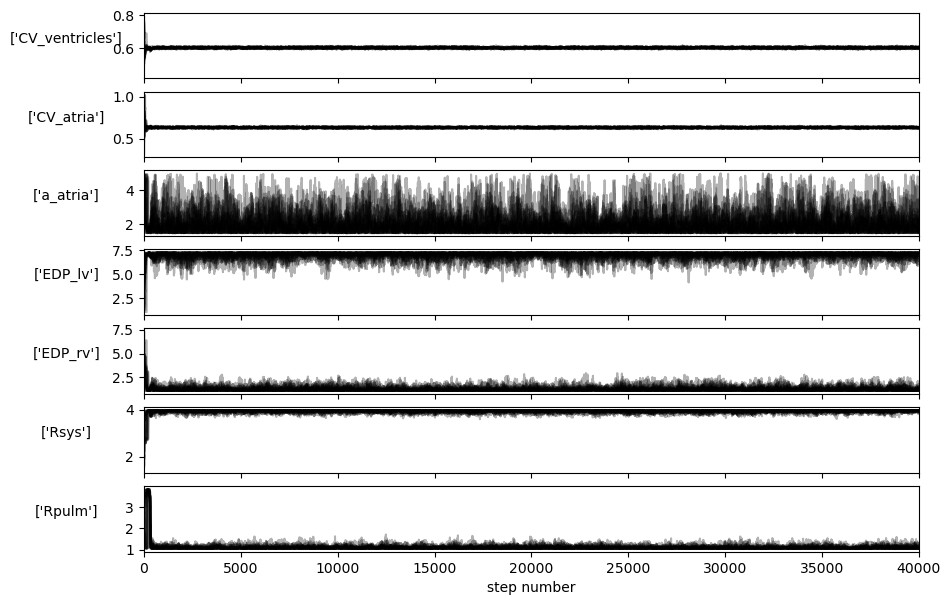

In [125]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [126]:
samp = pd.DataFrame(flat_samples).sample(50)

samp.to_csv("MCMC_samples_scenario_10_60.dat", sep = " ",index=False,header=None)

In [127]:
samp = pd.DataFrame(flat_samples)

samp.to_csv("MCMC_samples_scenario_10_60_full_posterior.dat", sep = " ",index=False,header=None)

In [128]:
torch.tensor(flat_samples.mean(axis=0))

tensor([0.6044, 0.6304, 2.0233, 6.9811, 1.2739, 3.9355, 1.0989],
       dtype=torch.float64)

In [129]:
pd.DataFrame(flat_samples).sample(50)

0         1         2         3         4         5         6
30556  0.605989  0.630547  2.316000  7.214315  1.282770  3.911214  1.069598
18263  0.605930  0.620542  2.227813  6.859311  1.321008  3.964692  1.079874
1876   0.607301  0.632895  2.535981  7.155710  1.173235  3.904534  1.193946
14041  0.616751  0.626757  2.136031  7.133393  1.117176  3.944458  1.089064
25881  0.600328  0.633737  1.622266  7.154254  1.286433  3.933263  1.197326
25302  0.603510  0.628678  1.872093  6.323552  1.141228  3.931136  1.115609
22877  0.596962  0.627148  2.430512  6.918646  1.242607  3.924869  1.058404
15930  0.604081  0.627510  1.639264  7.207997  1.156422  3.972843  1.066049
23727  0.606739  0.623657  1.652742  7.225922  1.475978  3.949956  1.119991
32212  0.608061  0.631983  2.931383  7.249949  1.082882  3.950259  1.104911
15923  0.606392  0.634997  1.785893  7.242804  1.345550  3.952523  1.200233
9246   0.602208  0.639549  2.270078  7.248365  1.113341  3.976905  1.042449
22256  0.603413  0.628588  1.907127  7.204662  1.112561  3.934068  1.155426
5711   0.603451  0.625766  1.989606  7.170291  1.169307  3.983816  1.156068
26961  0.607788  0.621459  2.037837  7.202414  1.354615  3.951184  1.210614
29034  0.607443  0.624965  1.871174  6.562434  1.266508  3.959149  1.053512
21191  0.601320  0.638719  3.162717  7.219774  1.212483  3.911527  1.056673
21828  0.601884  0.636487  1.519028  6.958794  1.381462  3.873008  1.150750
23981  0.604682  0.635096  1.613035  6.960908  1.192328  3.970003  1.077391
20516  0.603501  0.627730  1.945795  6.430475  1.222150  3.874968  1.070795
27589  0.602048  0.631528  1.504157  6.952148  1.086706  3.900421  1.061866
23147  0.603254  0.623920  1.692899  7.273660  1.130192  3.905268  1.068552
22799  0.608706  0.625997  1.958988  7.143034  1.824775  3.977939  1.075254
34592  0.601524  0.629926  2.320374  7.183563  1.158388  3.953292  1.184230
4811   0.612091  0.627902  2.025421  7.227760  1.073286  3.927151  1.047674
33536  0.599921  0.626484  2.144684  7.080312  1.078089  3.931925  1.051438
33164  0.598108  0.628974  2.440153  6.636066  1.286695  3.958145  1.062378
10409  0.601169  0.626505  1.815699  6.845190  1.139833  3.924490  1.102800
3695   0.604823  0.624779  1.515046  7.233592  1.339535  3.921126  1.043535
20137  0.601828  0.627799  1.835835  7.121311  1.161367  3.915178  1.070225
29713  0.612704  0.632358  1.589861  7.186511  1.402100  3.928479  1.098293
6389   0.609189  0.632095  1.973417  7.057997  1.089785  3.951057  1.046266
18329  0.600597  0.625948  2.874737  6.757211  1.291558  3.945119  1.108544
5269   0.608606  0.629926  1.862662  7.005589  1.140656  3.910266  1.144027
1601   0.600161  0.629982  1.791756  6.846611  1.065092  3.895645  1.166411
29537  0.604075  0.632999  2.564580  7.225095  1.457164  3.930264  1.051644
32386  0.603418  0.634548  1.732698  6.696026  1.235142  3.926891  1.218494
25866  0.603157  0.630447  1.703089  6.966072  1.180581  3.903675  1.124147
13857  0.606488  0.630092  1.894448  6.259076  1.378694  3.891240  1.107517
7910   0.603909  0.636365  1.960789  6.893233  1.306190  3.980347  1.074055
34137  0.603333  0.637263  1.481290  7.162579  1.257588  3.977040  1.145469
20581  0.607314  0.619436  1.931106  7.165341  1.078509  3.906606  1.079592
20209  0.602759  0.621353  2.042137  7.027231  1.084860  3.908779  1.198982
12842  0.601432  0.626310  1.569059  7.206547  1.454124  3.982679  1.038813
11615  0.601581  0.639065  1.825376  6.997466  1.072044  3.939649  1.076791
8365   0.603029  0.631404  2.035718  6.077340  1.263297  3.892023  1.053050
2109   0.604565  0.642153  3.094192  7.057343  1.243401  3.974651  1.048033
35420  0.607248  0.625803  1.957782  7.025195  1.126481  3.922749  1.110341
2562   0.602901  0.631022  1.566899  7.189261  1.219608  3.953878  1.146885
5246   0.601560  0.625463  2.435042  6.784507  1.352570  3.853554  1.075352

In [130]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None,:])

tensor([[133.8712,  99.9628, 126.4734,   0.3479]], grad_fn=<PermuteBackward0>)

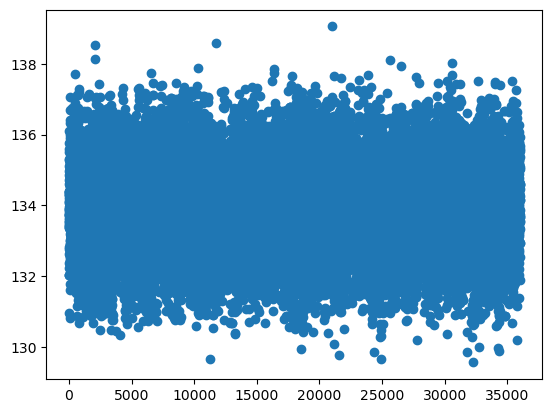

In [131]:
plt.plot(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0],'o')

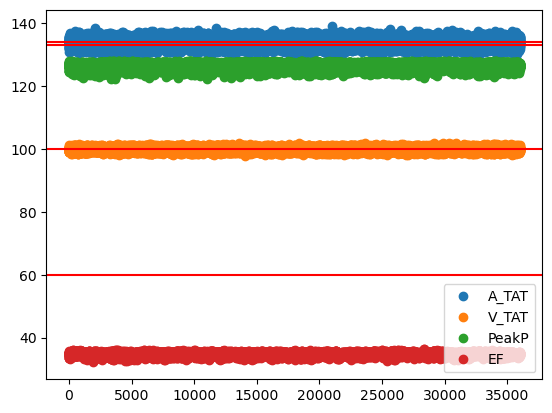

In [132]:
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,0:3].detach().numpy(),'o')
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy()*100,'o')
plt.legend(('A_TAT','V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=133, color='r', linestyle='-')
plt.axhline(y=100, color='r', linestyle='-')
plt.axhline(y=134, color='r', linestyle='-')
plt.axhline(y=0.6*100, color='r', linestyle='-')

In [133]:
posterior=pd.read_csv("MCMC_samples_scenario_10_40_full_posterior.dat",delim_whitespace=True,header=None)

In [134]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2
3


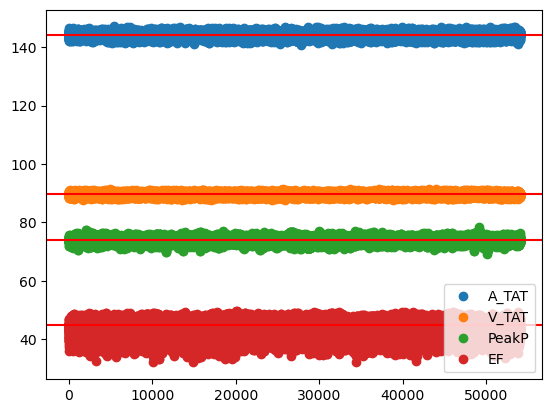

In [135]:
plt.plot(emulator.predict(torch.tensor(posterior.values))[:,0:3].detach().numpy(),'o')
plt.plot(emulator.predict(torch.tensor(posterior.values))[:,3].detach().numpy()*100,'o')
plt.legend(('A_TAT','V_TAT','PeakP','EF'),loc='lower right')

plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2], color='r', linestyle='-')
plt.axhline(y=y_test[3]*100, color='r', linestyle='-')


In [136]:
y_test

tensor([144.1990,  89.5618,  73.9400,   0.4480], dtype=torch.float64)

     CV_ventricles  CV_atria  a_atria   EDP_lv   EDP_rv     Rsys    Rpulm
0         0.583426  0.559737  2.63999  3.00130  4.86389  2.62436  1.74940
1         0.513584  0.679305  3.15695  5.65473  6.89338  2.07232  3.77998
2         0.528843  0.596498  4.85812  5.02497  2.16558  1.34170  2.09279
3         0.576382  0.320044  2.30249  3.45923  3.79267  1.44626  3.62270
4         0.706760  0.986539  1.47919  2.71888  3.53382  3.55907  3.37904
..             ...       ...      ...      ...      ...      ...      ...
995       0.492465  0.433849  3.11757  1.13969  5.68550  2.69079  1.14159
996       0.693082  0.775705  3.06761  3.16270  5.87700  2.03175  3.11116
997       0.383862  0.422026  3.75881  2.76191  7.32266  2.90629  2.73541
998       0.391658  0.580093  3.14632  7.38027  6.52224  3.83890  1.65956
999       0.488805  0.328415  4.39081  5.60215  1.67397  1.75135  3.87967

[1000 rows x 7 columns]
     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   167.78   

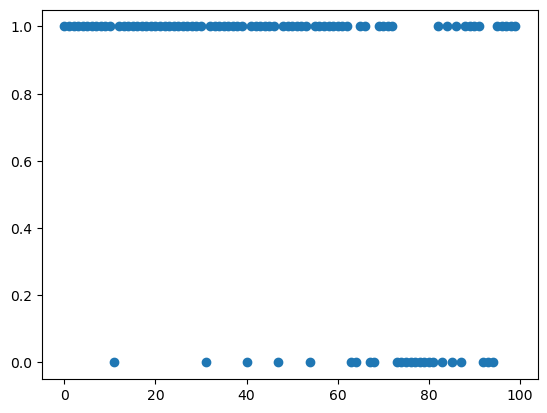

In [137]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [6]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [7]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.386498, 0.799253]
[0.305504, 1.02567]
[1.47919, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]
[1.02992, 3.98405]
[1.03672, 3.85692]


In [8]:
x_all = torch.tensor(input_masked.values)

y_calibration = y_all

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





In [9]:
y_max=y_calibration.max(axis=0)

In [10]:
y_max

torch.return_types.max(
values=tensor([ 1.8383e+02,  7.6800e+00,  1.4082e+02,  1.1758e+02,  2.1940e+03,
        -4.2800e+02,  1.8786e+02,  3.7800e+00,  1.3101e+02,  3.4090e+01,
         7.3700e+02, -1.4200e+02,  1.1299e+02,  1.0178e+02,  1.2501e+02,
         7.8600e+00,  9.8520e+01,  8.5390e+01,  1.1450e+02,  4.2600e+00,
         2.4440e+01,  1.4530e+01,  1.8630e+01,  1.8690e+01,  1.6870e+01,
         1.9490e+01,  2.8604e+02,  1.6145e+02,  4.4797e-01],
       dtype=torch.float64),
indices=tensor([18, 21, 40, 58, 58, 50, 26, 11, 31, 42, 42, 21, 52, 50,  9,  7, 26, 59,
        26, 29, 52, 43, 42, 43, 36, 36, 20, 41, 54]))

In [11]:
y_test = y_calibration[y_max[1][28],:]
x_test = x_all[y_max[1][28],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


In [12]:
emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [13]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 56
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test
obs_error=torch.ones(29)*0.1
obs_error[28]=0.001

In [14]:
obs_error

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.0010])

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [16]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,y_val))

-56646.1875
-162277.453125
-346481.78125
-134218.625
-365608.875
-44960.6796875
-166534.78125
-41787.515625
-62126.13671875
-588402.375
-284755.5625
-217821.921875
-206542.5625
-61799.890625
-101667.03125
-36888.234375
-20876.455078125
-291629.0625
-101277.21875
-209084.359375
-144382.859375
-344632.46875
-213251.25
-96989.96875
-236222.265625
-293359.53125
-21383.962890625
-19885.611328125
-42295.51953125
-58490.55859375
-44175.87109375
-356769.34375
-445805.59375
-159685.734375
-112820.46875
-157586.71875
-308165.625
-2570.22509765625
-171945.703125
-134867.96875
-115619.8203125
-160286.703125
-140660.4375
-29825.7734375
-19242.923828125
-13908.1591796875
-86943.984375
-171886.5
-84994.0234375
-433245.0
-137494.40625
-31251.806640625
-112212.3359375
-26889.595703125
-102583.5
-104572.5


In [17]:
sampler.run_mcmc(p0, 40000)

emcee: Exception while calling your likelihood function:
  params: [0.67112395 0.60019791 3.32028164 4.18029191 2.25190854 1.07881541
 2.52569099]
  args: [<GPE_ensemble.ensemble object at 0x2b26b4d10>, tensor([ 1.4309e+02,  4.3900e+00,  7.8990e+01,  7.3940e+01,  1.4880e+03,
        -5.8100e+02,  1.8312e+02,  3.0000e+00,  1.2033e+02,  3.0500e+01,
         6.6600e+02, -2.4800e+02,  9.3150e+01,  8.1890e+01,  1.0672e+02,
         4.4600e+00,  9.6660e+01,  8.2550e+01,  1.1111e+02,  3.4200e+00,
         1.1260e+01,  1.3570e+01,  1.5000e+01,  1.4110e+01,  1.4450e+01,
         1.6600e+01,  1.4420e+02,  8.9562e+01,  4.4797e-01],
       dtype=torch.float64)]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_10648/159059770.py", line 7, in log_prob
    return lp + log_likelihood(theta,emulator, y_val)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_10648/957054415.py", line 3, in log_likelihood
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py", line 295, in ensemble_log_likelihood_obs_error
    k = likelihoods[i](models[i](inputNorm)).covariance_matrix.diag()
                       ^^^^^^^^^^^^^^^^^^^^
  File "/Users/

KeyboardInterrupt: 

In [ ]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
x_test

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

samp.to_csv("MCMC_samples_scenario_10_40.dat", sep = " ",index=False,header=None)

In [ ]:
samp = pd.DataFrame(flat_samples)

samp.to_csv("MCMC_samples_scenario_10_40_full_posterior.dat", sep = " ",index=False,header=None)

In [ ]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

In [ ]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

In [ ]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

In [ ]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

In [ ]:
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,0:3].detach().numpy(),'o')
plt.plot(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy()*100,'o')
plt.legend(('A_TAT','V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=133, color='r', linestyle='-')
plt.axhline(y=100, color='r', linestyle='-')
plt.axhline(y=134, color='r', linestyle='-')
plt.axhline(y=0.6*100, color='r', linestyle='-')